# Final Procesamiento de Señales Biomédicas: Tema Emociones 

Alumnas: Priscilla Tenas Vai y Mercedes Galansky

Fecha de entrega: 14/2/22

## Montar drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# path necesarios editar aca para drive:
path0 = '/content/drive/Shareddrives/PSB FINAL/'
path1 = '/content/drive/Shareddrives/PSB FINAL/metadata_csv/participant_questionnaire.csv'
path011 = '/content/drive/Shareddrives/PSB FINAL/metadata_csv/participant_ratings.csv'
path = '/content/drive/Shareddrives/PSB FINAL/data_preprocessed_matlab/s'
'''
# path para JN - hay que comentar el google.colab:
path1 =  'C:/Users/p_ten/Downloads/metadata_csv/participant_questionnaire.csv'
path011 = 'C:/Users/p_ten/Downloads/metadata_csv/participant_ratings.csv'
path = 'C:/Users/p_ten/Downloads/data_preprocessed_matlab/s'
'''

"\n# path para JN - hay que comentar el google.colab:\npath1 =  'C:/Users/p_ten/Downloads/metadata_csv/participant_questionnaire.csv'\npath011 = 'C:/Users/p_ten/Downloads/metadata_csv/participant_ratings.csv'\npath = 'C:/Users/p_ten/Downloads/data_preprocessed_matlab/s'\n"

## Importar librerias

In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import math as m
import matplotlib.pyplot as plt
import random
import scipy.io
import scipy.interpolate

from matplotlib import patches
from matplotlib.figure import Figure
from matplotlib import rcParams

from scipy import io
from scipy import signal
from scipy.fft import fft
from scipy.signal import butter, lfilter


import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, chi2



! pip install control
import control

     |████████████████████████████████| 357 kB 5.3 MB/s 
  Created wheel for control: filename=control-0.9.1-py2.py3-none-any.whl size=364703 sha256=fd10130f7db25b608886d67ca74f06784944efea49dc0f094bdc18a6b45d9af8
  Stored in directory: /root/.cache/pip/wheels/b1/50/22/8005107713828997d1af664fbd629c7f935a1b87fc2f4ba6c1
Successfully built control


## Introducción 

En este trabajo se trata con el tema  de las emociones para poder clasificar las mismas a partir de la implementación de modelos aprendizaje automático. Para esto, se toman características relevantes de las señales extraídas de la base de datos DEAP. 

La base de datos consiste de 40 señales biológicas extraídas de 32 participantes mientras miraban 40 videos musicales de 1 minuto de largo, cada video se considera un trial distinto. Luego, se tomaron valores que los participantes clasificaron según etiquetas de Valencia, Arousal, Dominancia y Familiaridad.

En este trabajo se procesaran las siguientes señales periféricas:
* impedancia galvánica de la piel (GSR)
* fotopletismograma (PPG) 
* temperatura corporal (TMP)
* electroencefalograma (EEG)

La GSR proporciona una medida de la resistencia de la piel mediante la colocación de dos electrodos en las falanges distales de los dedos índice y medio. Esta resistencia disminuye debido al aumento de la transpiración, que suele producirse cuando se experimentan emociones como el estrés o la sorpresa. Además, se descubrió que el valor medio de la RSG está relacionado con el nivel de excitación.

El PPG mide el volumen de sangre en el pulgar del participante. Esta medición también puede utilizarse para calcular la frecuencia cardíaca (FC) mediante la identificación de los máximos locales, los períodos entre latidos y la variabilidad de la frecuencia cardíaca (VFC). La presión arterial y la VFC se correlacionan con las emociones, ya que el estrés puede aumentar la presión arterial y el carácter placentero de un estímulo puede aumentar la respuesta de la frecuencia cardíaca máxima. 

La TMP se registró ya que que varía con los diferentes estados emocionales.

Por último, las señales de EEG registran la actividad neuronal que se desarrolla en la corteza cerebral mediante electrodos. Presenta ritmos característicos: el ritmo delta (1-3 Hz), presente durante el sueño profundo; el ritmo theta (4-8 Hz), presente cuando la persona se encuentra en un estado de somnolencia como el sueño REM; el ritmo alfa (8-13 Hz), presente en una persona que se encuentra relajada; el ritmo beta (13-30 Hz), relacionado con la actividad neuronal intensa, en estados de alerta y atención; y el ritmo gamma (+30 Hz) presente en estados de vigilia. Las señales de EEG se relevan con ruido del electrooculograma (EOG) que deberá ser eliminado, por ejemplo mediante un filtro adaptativo de Wiener.

La emoción es un proceso psicofisiológico desencadenado por la percepción consciente y/o inconsciente de un objeto o una situación y suele asociarse con el estado de ánimo, el temperamento, la personalidad y la disposición, y la motivación. Las emociones desempeñan un papel importante en la comunicación humana y pueden expresarse verbalmente mediante un vocabulario emocional o mediante la expresión de señales no verbales como la entonación de la voz, las expresiones faciales y los gestos. La mayoría de los sistemas de interacción entre una persona y una computadora son deficientes en la interpretación de esta información, son incapaces de identificar los estados emocionales de los seres humanos y de utilizar esta información para decidir las acciones adecuadas a ejecutar.
Por ejemplo, el etiquetado implícito de de los vídeos utilizando información afectiva puede ayudar a los sistemas de recomendación y recuperación a mejorar su rendimiento. La base de datos utilizada se registra con el objetivo de crear un sistema de recomendación de vídeos musicales adaptable, en el que las respuestas fisiológicas de un usuario se traducirán en emociones. Las emociones de un usuario mientras ve los videoclips musicales ayudarán al sistema de recomendación a entender primero los gustos del usuario y, a continuación, a recomendar un clip musical que coincida con la emoción actual del usuario. 

En este trabajo se tienen en cuenta únicamente las características de valencia y arousal ya que son valores que explican adecuadamente la mayor parte de la variación de los estados emocionales, y son binarizados como agradable o desagradable y calmado (inactivo) o exitado (activo), respectivamente. Además, pueden relacionarse con la escala de valencia-arousal de Russell, para describir cuantitativamente las emociones. En esta escala, cada estado emocional puede situarse en un plano 2D con la excitación (arousal) y la valencia como ejes horizontal y vertical. Para la autoevaluación según estas escalas, se utilizaron los conocidos maniquíes de autoevaluación.

Además, se tendrán en cuenta únicamente los primeros 22 participantes ya que sus muestras fueron tomadas en el mismo lugar (Twente) mientras que los otros 10 fueron tomados en otro (Geneva), y al desarrollar el trabajo se opta por eliminarlos para conseguir uniformidad en los datos. [1]

In [4]:
participant_questionnaire = pd.read_csv(path1)
participant_questionnaire = participant_questionnaire
cantParticipantes = len(participant_questionnaire)
cantParticipantesT = 22
cantParticipantesF = len(participant_questionnaire.loc[participant_questionnaire['Gender']=='Female'])
cantParticipantesM = len(participant_questionnaire.loc[participant_questionnaire['Gender']=='Male'])

edadMinima = np.min(participant_questionnaire['Age'])
edadMaxima = np.max(participant_questionnaire['Age'])
print('Cantidad de participantes:', str(cantParticipantes),'donde',str(cantParticipantesF),'son femeninos y',str(cantParticipantesM),'masculinos')

print('Los participantes se encuentran en el siguiente rango etario:', edadMinima, 'hasta', edadMaxima)


Cantidad de participantes: 32 donde 15 son femeninos y 17 masculinos
Los participantes se encuentran en el siguiente rango etario: 19 hasta 37


In [5]:
participant_ratings = pd.read_csv(path011)
participant_ratings = participant_ratings
participant_ratings.loc[participant_ratings['Participant_id']==1]

Participant_id  Trial  Experiment_id  ...  Dominance  Liking  Familiarity
0                1      1              5  ...       7.19    6.05          4.0
1                1      2             18  ...       6.94    8.01          4.0
2                1      3              4  ...       6.12    8.06          4.0
3                1      4             24  ...       8.01    8.22          4.0
4                1      5             20  ...       7.19    8.13          1.0
5                1      6             31  ...       2.86    8.04          1.0
6                1      7             40  ...       6.17    5.97          3.0
7                1      8             39  ...       7.87    6.15          1.0
8                1      9             13  ...       2.87    6.18          1.0
9                1     10             33  ...       4.78    5.13          1.0
10               1     11              6  ...       7.00    8.03          2.0
11               1     12             10  ...       2.04    7.09          2.0
12               1     13             35  ...       8.05    5.18          1.0
13               1     14             22  ...       7.06    7.37          1.0
14               1     15             15  ...       2.91    5.04          1.0
15               1     16             17  ...       6.77    6.41          4.0
16               1     17             36  ...       6.50    3.87          1.0
17               1     18             34  ...       7.28    6.92          1.0
18               1     19             14  ...       3.04    5.04          4.0
19               1     20             27  ...       7.03    7.29          4.0
20               1     21             11  ...       3.63    6.24          1.0
21               1     22             30  ...       3.22    7.33          2.0
22               1     23             29  ...       3.00    8.14          2.0
23               1     24              1  ...       6.90    7.83          5.0
24               1     25              7  ...       7.08    7.04          2.0
25               1     26             32  ...       3.27    3.95          4.0
26               1     27             12  ...       3.40    7.35          1.0
27               1     28             16  ...       8.15    7.14          3.0
28               1     29             25  ...       8.65    7.21          2.0
29               1     30             28  ...       4.01    7.87          1.0
30               1     31              8  ...       6.32    5.87          4.0
31               1     32              3  ...       9.00    7.08          5.0
32               1     33             38  ...       6.54    6.62          1.0
33               1     34             37  ...       3.10    6.77          1.0
34               1     35             19  ...       8.10    6.79          4.0
35               1     36              2  ...       7.28    8.47          2.0
36               1     37             21  ...       8.37    7.86          2.0
37               1     38             23  ...       7.37    7.90          1.0
38               1     39              9  ...       3.62    5.99          5.0
39               1     40             26  ...       7.41    8.24          3.0

[40 rows x 9 columns]

## Cargado de datos
Inicialmente, se procede a leer los datos que se encuentran en la carpeta de la base de datos para poder procesarlos. Se deben tener en cuenta las valoraciones. 

In [6]:
participantes = []

for i in range(0, cantParticipantes):
  if i < 9:
    pi = path + '0' + str(i+1) + '.mat'
  else:
    pi = path + str(i+1) + '.mat'
  participantes.append(sp.io.loadmat(pi)) # quedan como diccionarios

Una vez cargados los datos se debe observar como estan compuestos los mismos para poder llevar a cabo un tratamiento correcto. Para esto se procede a observar los datos del primer participante, sabiendo que la base de datos de cada uno esta compuesta por trials x señales x tiempo. Se espera que las primeras dos tengan un valor de 40 y el tiempo que sea de aproximadamente 8000 muestras. La matriz de labels debe tener dimensiones (shape) de 40x4. 

Lo que nosotros llamamos trial corresponde al experiment id en la tabla de participant_ratings.

In [7]:
p0 = participantes[0]
print('A continuacion se muestran las keys del diccionario de p0 (son las mismas para todos):\n', p0.keys())
# entonces lo unico que nos importa de esto son 'data' y 'labels'
matrizDatos0 = p0['data'] 
trials0, senales0, muestras0 = matrizDatos0.shape
matrizLabels0 = p0['labels']

print('Como es de esperarse la matriz de datos tiene un shape =', matrizDatos0.shape, 
      'siendo trials = ', trials0, ', señales =', senales0, 'y tiempo = ', muestras0, 'muestras')
print('Como es de esperarse la matriz de labels tiene un shape =', matrizLabels0.shape)

A continuacion se muestran las keys del diccionario de p0 (son las mismas para todos):
 dict_keys(['__header__', '__version__', '__globals__', 'labels', 'data'])
Como es de esperarse la matriz de datos tiene un shape = (40, 40, 8064) siendo trials =  40 , señales = 40 y tiempo =  8064 muestras
Como es de esperarse la matriz de labels tiene un shape = (40, 4)


Se debe chequear que todas las matrices a utilizar tengan las mismas dimensiones.

In [8]:
for i in range(cantParticipantes):
  pi = participantes[i]
  if pi['data'].shape != (40, 40, 8064):
    print('error en data:', i+1)
  elif pi['labels'].shape != (40,4):
    print('error en labels:', i+1)

A partir de esto, se realiza el siguiente tratamiento de datos para obtener una lista unificada de datos, y luego de esta forma extraer solo las señales de interés. 

In [9]:
# np array de [participante,trial, senales, muestras]
datos = np.zeros([cantParticipantes, trials0, senales0, muestras0])
labels = np.zeros([cantParticipantes,matrizLabels0.shape[0],matrizLabels0.shape[1]])
print(datos.shape)
for i in range(cantParticipantes):
  pi = participantes[i]
  datos[i] = pi['data']
  labels[i] = pi['labels']

# chequeamos que los shapes se mantengan: 
print('labels.shape =', labels.shape, '\ndatos.shape =', datos.shape)

(32, 40, 40, 8064)
labels.shape = (32, 40, 4) 
datos.shape = (32, 40, 40, 8064)


## Señales fisiológicas



### Señales periféricas
Como se menciono anteriormente, se utilizaran las siguientes señales fisiológicas periféricas:

* impedancia galvánica de la piel (GSR)
* fotopletismograma (PPG) 
* temperatura corporal (TMP)

Se procede a filtrar las mismas de la base de datos para cada uno de los 32 participantes, mediante el siguiente código.

La frecuencia de muestreo ($F_s$) de dichas señales para su relevamiento fue de 512 Hz pero se realiza un downsampling a 128 Hz (para reducir el tiempo de procesamiento), por lo que tambien se establece el vector tiempo t y vector en frecuencias f. 

In [10]:
datosFiltrados = datos[:,:,[36, 37, 38, 39],:]
GSR = datosFiltrados[:,:,0,:] # senal 36 corresponde a la impedancia galvanica de la piel
RespBelt = datosFiltrados[:,:,1,:] 
PPG = datosFiltrados[:,:,2,:] # senal 38 corresponde a la fotopletismograma
TMP = datosFiltrados[:,:,3,:] # senal 39 corresponde a la temperatura corporal

Fs = 128 #[Hz]
t = np.linspace(0, muestras0/Fs, muestras0) # vector de tiempo segun las muestras que tenemos y la frecuencia de muestreo
f = scipy.fft.fftfreq(muestras0, 1/Fs)

Una vez obtenidas las señales se debe observar si se preprocesaron correctamente. Para esto, se grafican algunos de los datos obtenidos del primer participante. Se observan dos trials aleatorios del mismo.

In [11]:
nTrials = np.linspace(0,trials0-1,trials0)
n1 = int(random.choice(nTrials))
nTrials = np.delete(nTrials, n1)
n2 = int(random.choice(nTrials))

trialn1 = datosFiltrados[0,n1,:,:]
trialn2 = datosFiltrados[0,n2,:,:]

# senales para trial n1
GSR_n1 = trialn1[0,:] # impedancia galvanica de la piel
RespBelt_n1 = trialn1[1,:] # respiration belt
PPG_n1 = trialn1[2,:] # fotopletismograma
TMP_n1 = trialn1[3,:] # temperatura corporal

# senales para trial n2
GSR_n2 = trialn2[0,:] # impedancia galvanica de la piel
RespBelt_n2 = trialn2[1,:] # respiration belt
PPG_n2 = trialn2[2,:] #  fotopletismograma
TMP_n2 = trialn2[3,:] # temperatura corporal

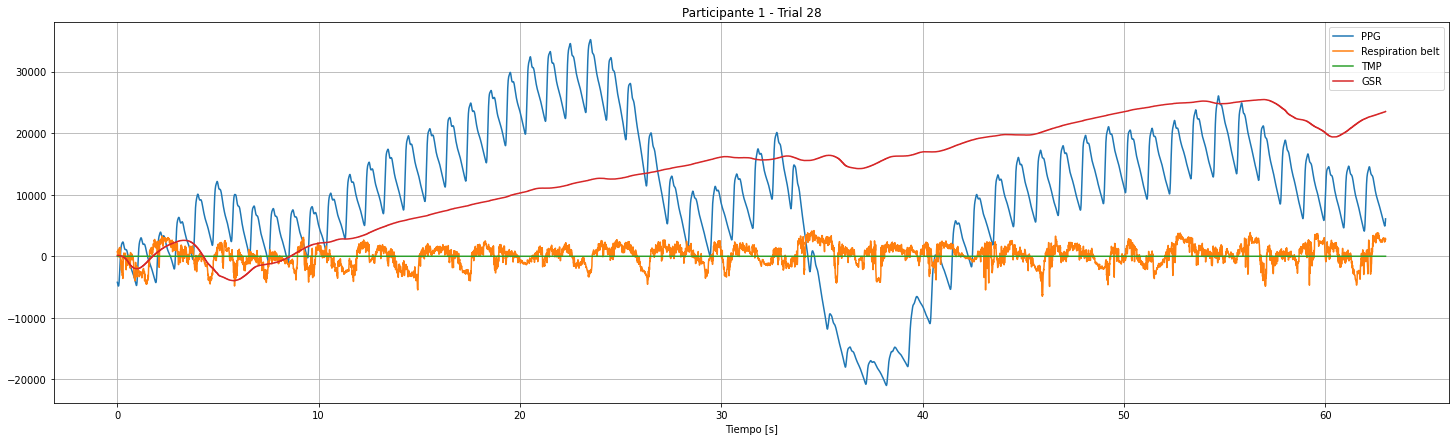

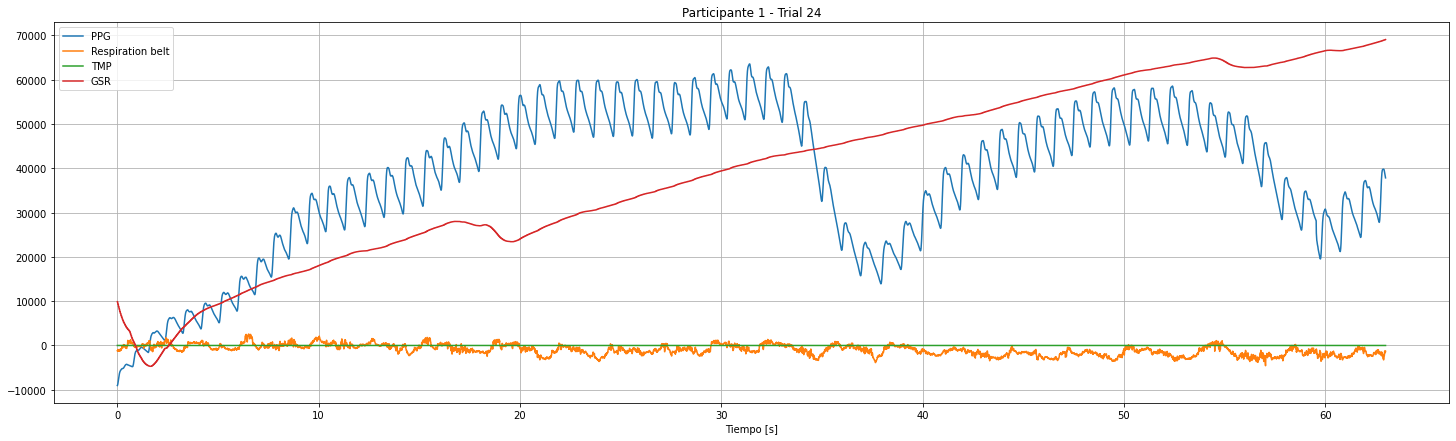

In [12]:
# codigo graficos

plt.figure(figsize=[25,7])
plt.plot(t,PPG_n1,label='PPG')
plt.plot(t,RespBelt_n1,label='Respiration belt')
plt.plot(t,TMP_n1,label='TMP')
plt.plot(t,GSR_n1,label='GSR')
plt.title('Participante 1 - Trial ' + str(n1+1))
plt.legend()
plt.xlabel('Tiempo [s]')
plt.grid()
plt.show()

plt.figure(figsize=[25,7])
plt.plot(t,PPG_n2,label='PPG')
plt.plot(t,RespBelt_n2,label='Respiration belt')
plt.plot(t,TMP_n2,label='TMP')
plt.plot(t,GSR_n2,label='GSR')
plt.title('Participante 1 - Trial ' + str(n2+1))
plt.legend()
plt.xlabel('Tiempo [s]')
plt.grid()
plt.show()



### EEG

Por otro lado, se toman 8 derivaciones de EEG que son las siguientes: 
f3 (canal 3), f4 (canal 20), f7 (canal 4), f8 (canal 21), t7 (canal 8), t8 (canal 26), p7 (canal 12), p8 (canal 30). 

Estas señales de la DEAP tienen aplicado un filtro pasabanda de 4 - 45 Hz, por lo que se considera que no debe realizarse otro filtrado de frecuencias para su preprocesamiento.

In [13]:
f3EEG = datos[:,:,2,:]
f4EEG = datos[:,:,19,:]
f7EEG = datos[:,:,3,:] 
f8EEG = datos[:,:,20,:] 
t7EEG = datos[:,:,7,:]
t8EEG = datos[:,:,25,:] 
p7EEG = datos[:,:,11,:] 
p8EEG = datos[:,:,29,:] 

Se observan a continuación las 8 derivaciones para el primer participante seleccionando un trial aleatorio n1.

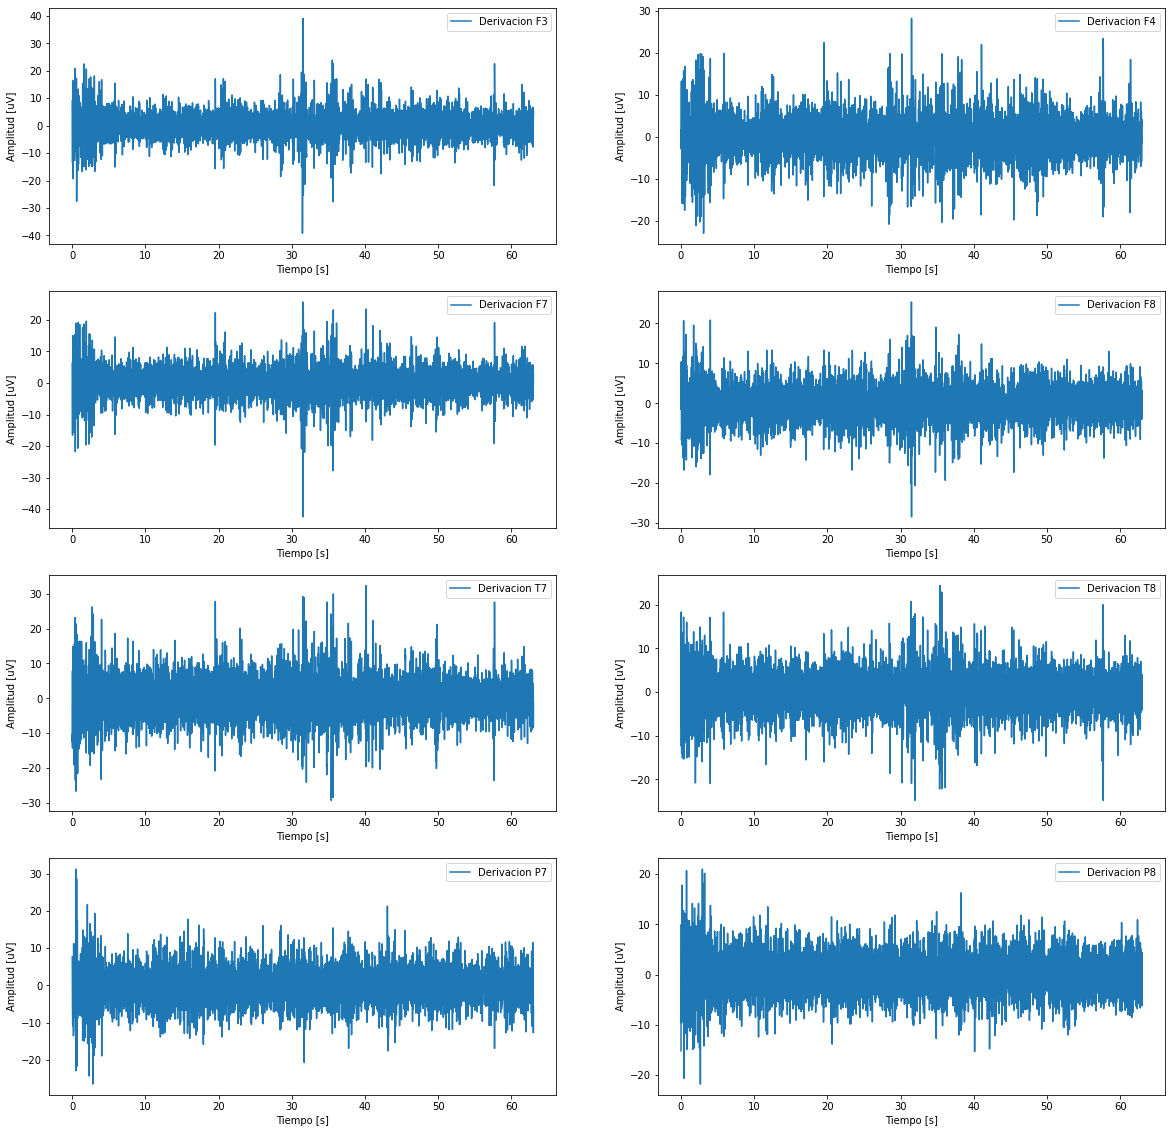

In [14]:
plt.figure(figsize=(20,20))
plt.title('EEG - Participante 0 - Trial '+ str(n1+1))


plt.subplot(4,2,1)
plt.plot(t,f3EEG[0,n1,:], label = 'Derivacion F3')
plt.ylabel('Amplitud [uV]') 
plt.xlabel('Tiempo [s]')
plt.legend()

plt.subplot(4,2,2)
plt.plot(t,f4EEG[0,n1,:], label = 'Derivacion F4')
plt.ylabel('Amplitud [uV]') 
plt.xlabel('Tiempo [s]')
plt.legend()

plt.subplot(4,2,3)
plt.plot(t,f7EEG[0,n1,:], label = 'Derivacion F7')
plt.ylabel('Amplitud [uV]') 
plt.xlabel('Tiempo [s]')
plt.legend()

plt.subplot(4,2,4)
plt.plot(t,f8EEG[0,n1,:], label = 'Derivacion F8')
plt.ylabel('Amplitud [uV]') 
plt.xlabel('Tiempo [s]')
plt.legend()

plt.subplot(4,2,5)
plt.plot(t,t7EEG[0,n1,:], label = 'Derivacion T7')
plt.ylabel('Amplitud [uV]') 
plt.xlabel('Tiempo [s]')
plt.legend()

plt.subplot(4,2,6)
plt.plot(t,t8EEG[0,n1,:], label = 'Derivacion T8')
plt.ylabel('Amplitud [uV]') 
plt.xlabel('Tiempo [s]')
plt.legend()

plt.subplot(4,2,7)
plt.plot(t,p7EEG[0,n1,:], label = 'Derivacion P7')
plt.ylabel('Amplitud [uV]') 
plt.xlabel('Tiempo [s]')
plt.legend()

plt.subplot(4,2,8)
plt.plot(t,p8EEG[0,n1,:], label = 'Derivacion P8')
plt.ylabel('Amplitud [uV]') 
plt.xlabel('Tiempo [s]')
plt.legend()

plt.show()

También se extrayeron las señales de EOG para un análisis posterior del EEG. 

In [15]:
EOGh = datos[:,:,33,:]
EOGv = datos[:,:,34,:]

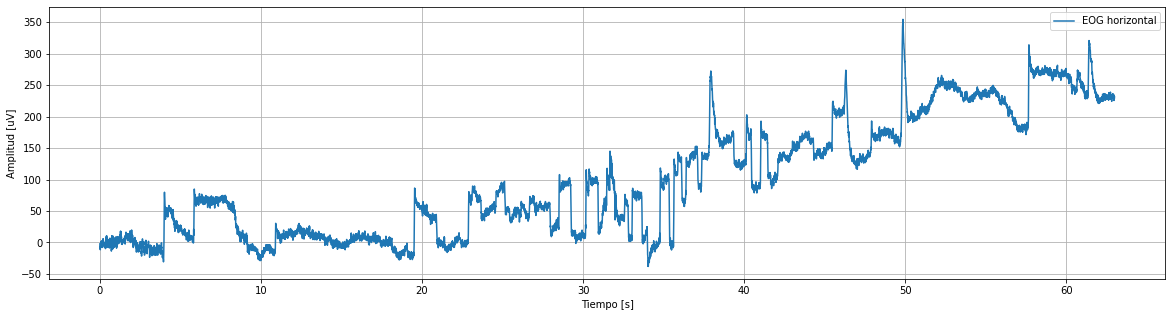

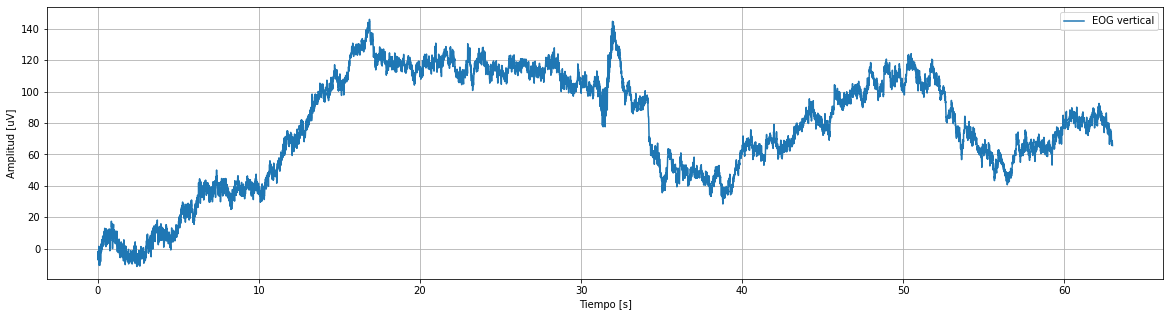

In [16]:
plt.figure(figsize=[20,5])
plt.plot(t,EOGh[0,n1,:], label = 'EOG horizontal')
plt.ylabel('Amplitud [uV]') # hay que buscar en que unidad está
plt.xlabel('Tiempo [s]')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=[20,5])
plt.plot(t,EOGv[0,n1,:], label = 'EOG vertical')
plt.ylabel('Amplitud [uV]') # hay que buscar en que unidad está
plt.xlabel('Tiempo [s]')
plt.legend()
plt.grid()
plt.show()

## Etiquetas de Valencia y Arousal
Se utilizan las dos primeras columnas de labels, que contienen las valoraciones de Valencia y Arousal. Estas están valoradas entre 1 y 9 inclusive y se desea obtenerlas de forma binaria, por lo que se busca que queden definidas mediante valores positivos y negativos, para hacer posteriormente la clasificación.

In [17]:
print(np.median(labels[:,:,0].copy()) )
print(np.mean(labels[:,:,0]))

5.04
5.2543125


In [18]:
labelsB = labels[:,:,0:2].copy() # solamente nos quedamos con los labels de valencia y Arousal
meanValencia = np.mean(labels[:,:,0])
meanArousal = np.mean(labels[:,:,1])
labelsB[:,:,0] = labels[:,:,0]- meanValencia # valencia
labelsB[:,:,1] = labels[:,:,1]- meanArousal # Arousal
labelsB[labelsB>=0] = 1
labelsB[labelsB<0] = 0

In [19]:
labelsB2 = labels[:,:,0:2].copy() # solamente nos quedamos con los labels de valencia y Arousal
labelsB2[:,:,0] = labels[:,:,0]- 5 # valencia
labelsB2[:,:,1] = labels[:,:,1]- 5 # Arousal
labelsB2[labelsB2>=0] = 1
labelsB2[labelsB2<0] = 0

Las variables de Valencia y Arousal fueron binarizadas de dos maneras distintas, para observar sus resultados y así concluir cuál sería la forma más óptima de hacerlo. Una manera consiste en restar la media de los valores obtenidos a cada uno, la cual tiene en cuenta como fue valorada cada una para el criterio de binarizado. La otra consiste en restarle el valor medio de la escala que se tomó para caracterizar la variable, la cual podría considerarse una forma más objetiva de binarizar los resultados. 

In [20]:
np.unique(labelsB==labelsB2, return_counts=True)

(array([False,  True]), array([ 236, 2324]))

Entre ambas formas de binarizar las variables se puede observar que hay una diferencia en el clasificado de 236 de los valores. 

## Procesamiento de señales

Se realiza un tratamiento de las señales para su posterior análisis mediante filtrados que se consideran acordes para una mejor interpretación de cada señal, basandose en lo establecido en la base de datos.

### Funciones 

Se define la función LMS (Least Mean-Square algorithm) que consiste en un algoritmo que utiliza señales de referencia combinadas linealmente para la cancelación de artefactos considerados como ruido, mediante la minimización del cuadrado de la diferencia entre una señal deseada y su estimación obtenida a la salida, la cual se encuentra definida por el error cuadrático medio. Por lo tanto, a través de dicho algoritmo, se toma una señal de entrada y una de referencia y utilizando el método del gradiente descendiente o descenso más pronunciado, que es un método que consiste en calcular el gradiente de la superficie del error y converger en una magnitud constante (delta) en dirección del descenso más pronunciado recursivamente, se garantiza la convergencia al mínimo error cuadrático medio. De manera muy similar a lo que establece la teoría de filtros Weiner, los parámetros del proceso lineal que lleva a cabo el algoritmo lms son los coeficientes óptimos de un filtro FIR, utilizados porque son filtros estables y pueden ser implementados mediante una convolución, los coeficientes se inicializan en cero y se van actualizando mediante la multiplicación del error por la constante delta a medida que se va desplazando a través de la longitud de la señal de entrada. El valor de delta se define a criterio de cada usuario ya que si es grande se converge más rápido al mínimo pero pierde estabilidad y a medida que se achica el valor esto mejora pero es más complejo computacionalmente. [3]

El análisis está llevado a cabo para señales en estado estacionario, por lo que dicho algoritmo converge en la media a la solución óptima, que es el error mínimo. [4]



In [21]:
def lms(entrada,deseada,L,delta): #L : orden # lms: least mean square (cuadrados minimos)
  M = entrada.shape[0]
  b = np.zeros([1,L]) # coeficientes del filtro
  y = np.zeros([1,M]) # salida
  e = np.zeros([1,M]) # error

  for i in range (L, M): 
    x1 = entrada[i: i - L: -1]  # lo que voy a aprender para optimizar los coeficientes en cada iteración
    y[0,i] = b.dot(x1)   #"lo que aprendi" "señal filtrada" "convolución"
    e[0,i] = deseada[i] - y[0,i] 
    b = b + delta * e[0,i] * x1

  return b, y, e
 

La función lms_derivaciones se define para aplicar el algoritmo de lms a todas las derivaciones de EEG. La constante de convergencia que se le ingresa a la función es a, pero como debe estar definida en el rango entre 0 y $\frac{1}{10*L*potencia}$ se calcula el parámetro dentro de la función.

In [22]:
# funcion para pasar el lms por todos las derivaciones que tenemos:
def lms_derivaciones(entradas, deseadas, a, L): 
  a0,b0,c0 = entradas.shape
  salida = np.zeros([a0,b0,c0])
  for i in range(a0):
    for j in range(b0):  
      entrada = entradas[i,j,:]
      deseada = deseadas[i,j,:]
      potencia = np.mean(entrada**2)
      delta = a / (10*L*potencia) # constante de convergencia
      b, y, e = lms(entrada,deseada,L,delta)
      salida[i,j] = y
  return salida

Se define la función Zplane la cual grafíca en el plano complejo (eje imaginario vertical y eje real horizonatal) los polos y ceros de la función de transferencia de un filtro, a partir de los coeficientes del polinomio del numerador y del denominador. Esta representación brinda información sobre los valores donde la ganancia del filtro va a tender a cero y donde va a tender a infinito (polos).

In [23]:
def zplane(b,a,filename=None): # a: coeficientes del denominador, b: coeficientes del numerador
    # get a figure/plot
    plt.figure(figsize=(7,7))
    ax = plt.subplot(111)

    # create the unit circle
    uc = patches.Circle((0,0), radius=1, fill=False,
                        color='black', ls='dashed')
    ax.add_patch(uc)

    # The coefficients are less than 1, normalize the coeficients
    if np.max(b) > 1:
        kn = np.max(b)
        b = b/float(kn)
    else:
        kn = 1

    if np.max(a) > 1:
        kd = np.max(a)
        a = a/float(kd)
    else:
        kd = 1
        
    # Get the poles and zeros
    p = np.roots(a)
    z = np.roots(b)
    k = kn/float(kd)
    
    # Plot the zeros and set marker properties    
    t1 = plt.plot(z.real, z.imag, 'go', ms=10)
    plt.setp( t1, markersize=10.0, markeredgewidth=1.0,
              markeredgecolor='k', markerfacecolor='g')

    # Plot the poles and set marker properties
    t2 = plt.plot(p.real, p.imag, 'rx', ms=10)
    plt.setp( t2, markersize=12.0, markeredgewidth=3.0,
              markeredgecolor='r', markerfacecolor='r')

    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # set the ticks
    r = 1.5; plt.axis('scaled'); plt.axis([-r, r, -r, r])
    ticks = [-1, -.5, .5, 1]; plt.xticks(ticks); plt.yticks(ticks)

    if filename is None:
        plt.show()
    else:
        plt.title(filename)
        plt.show()
    

    return z, p, k

La función plot_H grafica el diagrama de Bode de un filtro a partir de las frecuencias (w, en las mismas unidades que la frecuencia de muestreo fs) normalizadas en el rango [0, pi) y la respuesta en frecuencia (h). Marcando con una linea punteada donde se encuentra la frecuencia de corte (wCorte). Se opta por implementar filtros Butterworth y por eso se incluye en el título del gráfico, esto se debe a que es un filtro básico cuya respuesta es muy plana hasta la frecuencia de corte.

In [24]:
def plot_H(w,h,wCorte,fs):
  plt.plot((fs/(2*np.pi)) * w, abs(h)) 
  plt.title('Butterworth filter frequency response')
  plt.xlabel('Frecuencia [Hz]')
  plt.ylabel('Amplitud')
  plt.grid()
  plt.xlim([0,50])
  for i in range(len(wCorte)):
    plt.axvline(wCorte[i], color='green',linestyle = 'dashed') # cutoff frequency
  plt.show()

### GSR y TMP
Para el tratado de estas señales se utiliza un filtro pasa bajos para obtener las frecuencias de la señal entre 0 y 2 Hz (frecuencia de corte provista por la cátedra). El orden del filtro se toma de 4 porque brinda una buena precisión para atenuar las frecuencias mayores a 2 Hz y al ser un filtro digital no presenta dificultades en su aplicación. 




In [25]:
wCorte = 2
orden = 4
# hay que ver como establecer el orden y el valor de corte bien porque no se estaria modificando mucho si usamos 2 o 4 de orden por ej
numerador, denominador = butter(orden, wCorte, fs = Fs, btype = 'low') 

GSRfiltrado = signal.filtfilt(numerador, denominador, GSR)
TMPfiltrado = signal.filtfilt(numerador, denominador, TMP)

Se analiza el sistema de orden establecido mediante su función de transferencia, observando el diagrama de polos y ceros del mismo, asi como el diagrama de Bode.

HButter =  
5.123e-06 z^4 + 2.049e-05 z^3 + 3.074e-05 z^2 + 2.049e-05 z + 5.123e-06
-----------------------------------------------------------------------
            z^4 - 3.744 z^3 + 5.263 z^2 - 3.293 z + 0.7736

dt = 0.0078125



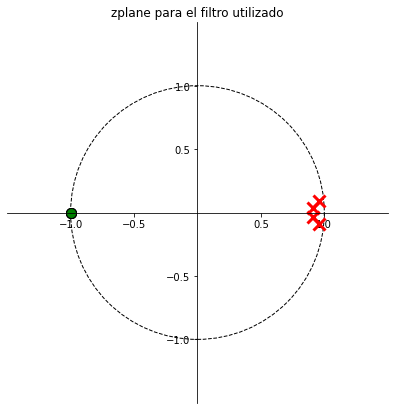

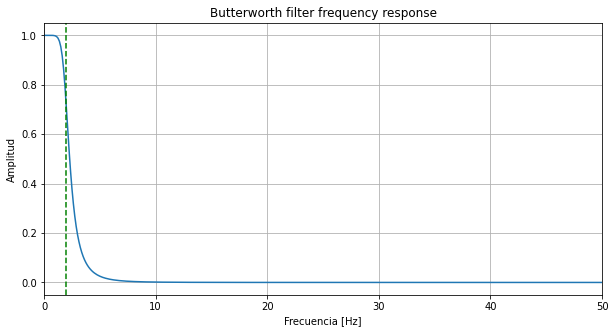

In [26]:
# Función de transferencia
HButter = control.tf(numerador, denominador, 1/Fs)
print('HButter = ', HButter)

# Diagrama de polos y ceros
ceros, polos, k = zplane(numerador,denominador,filename="zplane para el filtro utilizado")

# Gráfico de la función de transferencia
w1, h1 = signal.freqz(numerador, denominador)
plt.figure(figsize=[10,5])
plot_H(w1,h1,[wCorte],Fs)

Se procede a observar las señales obtenidas antes y despues de aplicar los filtros para comparar los comportamientos de cada una. Para esto se realiza un acercamiento en una porción de la señal, ya que permite distinguir mejor las diferencias. Se observan tanto en tiempo como en frecuencia.

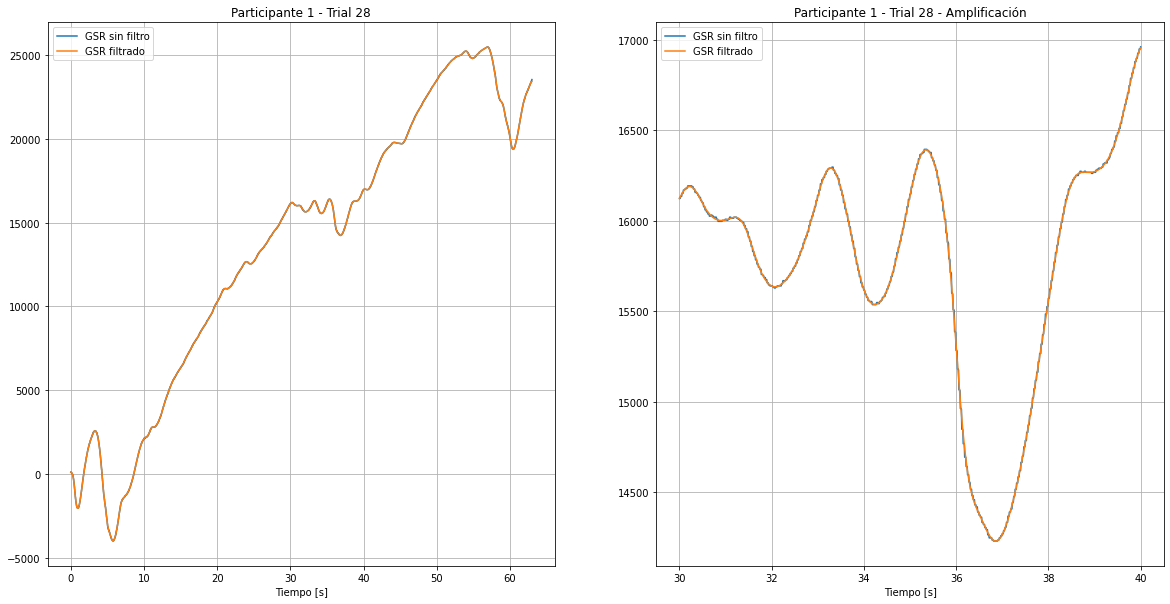

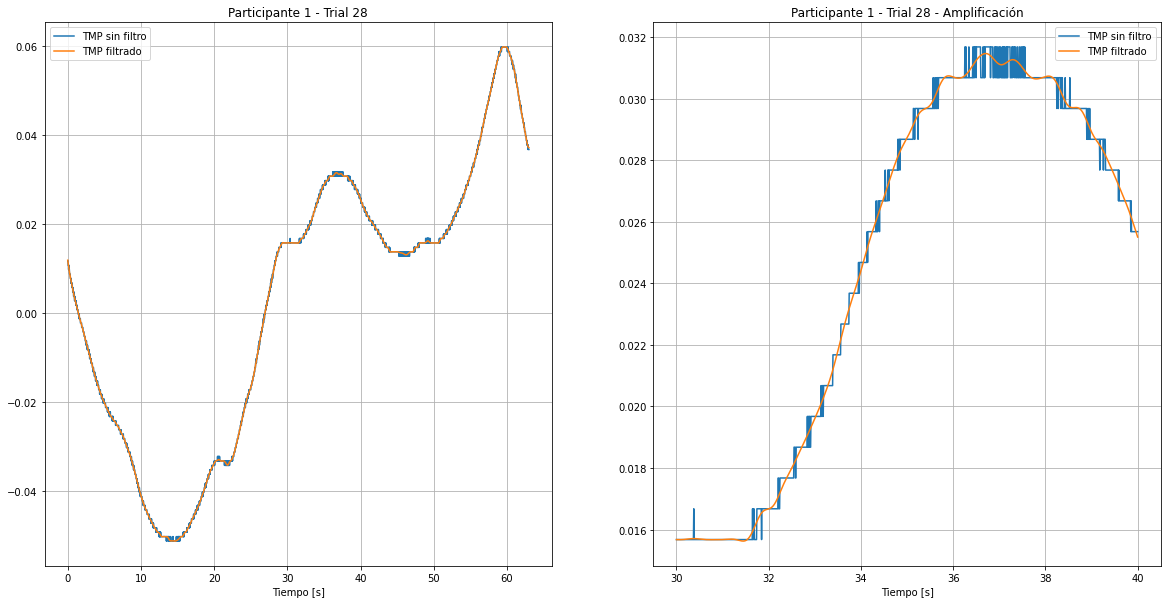

In [27]:
# en tiempo # ojo lo que comente arriba que dice para ver cual se comporta mejor
t1,t2 = 30*Fs,40*Fs

GSR0_n1 = GSR[0,n1,:]
GSRfiltrado0_n1 = GSRfiltrado[0,n1,:]

plt.figure(figsize=[20,10])
plt.subplot(121)
plt.plot(t,GSR0_n1,label='GSR sin filtro') # [participante9, trialn1, datos]
plt.plot(t,GSRfiltrado0_n1,label='GSR filtrado')
plt.title('Participante 1 - Trial ' + str(n1+1))
plt.legend()
plt.xlabel('Tiempo [s]')
plt.grid()

plt.subplot(122)
plt.plot(t[t1:t2],GSR0_n1[t1:t2],label='GSR sin filtro') # [participante9, trialn1, datos]
plt.plot(t[t1:t2],GSRfiltrado0_n1[t1:t2],label='GSR filtrado')
plt.title('Participante 1 - Trial ' + str(n1+1) + ' - Amplificación')
plt.legend()
plt.xlabel('Tiempo [s]')
plt.grid()


TMP0_n1 = TMP[0,n1,:]
TMPfiltrado0_n1 = TMPfiltrado[0,n1,:]

plt.figure(figsize=[20,10])
plt.subplot(121)
plt.plot(t,TMP0_n1,label='TMP sin filtro') # [participante9, trialn1, datos]
plt.plot(t,TMPfiltrado0_n1,label='TMP filtrado')
plt.title('Participante 1 - Trial ' + str(n1+1))
plt.legend()
plt.xlabel('Tiempo [s]')
plt.grid()

plt.subplot(122)
plt.plot(t[t1:t2],TMP0_n1[t1:t2],label='TMP sin filtro') # [participante9, trialn1, datos]
plt.plot(t[t1:t2],TMPfiltrado0_n1[t1:t2],label='TMP filtrado')
plt.title('Participante 1 - Trial ' + str(n1+1) + ' - Amplificación')
plt.legend()
plt.xlabel('Tiempo [s]')
plt.grid()

plt.show()

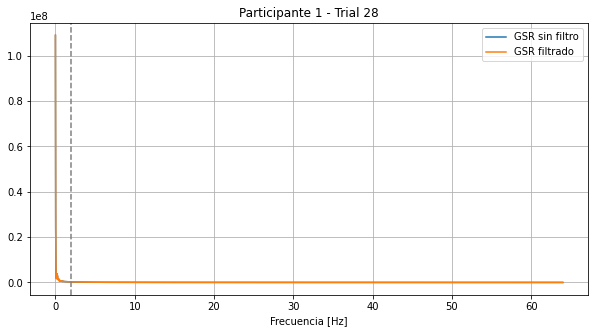

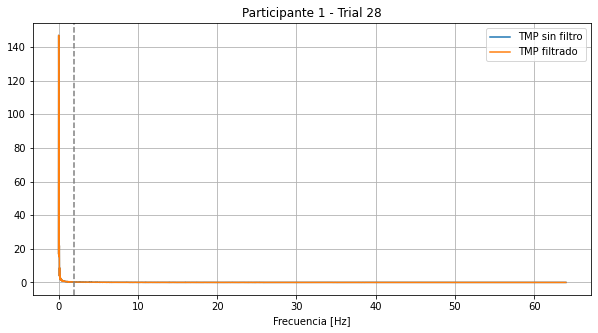

In [28]:
# en frecuencia
fmax = int(muestras0/2)

GSR0_n1fft = np.abs(np.fft.fft(GSR[0,n1,:]))
GSRfiltrado0_n1fft = np.abs(np.fft.fft(GSRfiltrado[0,n1,:]))

plt.figure(figsize=[10,5])
plt.plot(f[0:fmax], GSR0_n1fft[0:fmax], label = 'GSR sin filtro')
plt.plot(f[0:fmax], GSRfiltrado0_n1fft[0:fmax], label = 'GSR filtrado')
plt.axvline(wCorte, color = 'gray', linestyle = 'dashed')
plt.title('Participante 1 - Trial ' + str(n1+1))
plt.legend()
plt.xlabel('Frecuencia [Hz]')
plt.grid()
plt.show()

TMP0_n1fft = np.abs(np.fft.fft(TMP[0,n1,:]))
TMPfiltrado0_n1fft = np.abs(np.fft.fft(TMPfiltrado[0,n1,:]))

plt.figure(figsize=[10,5])
plt.plot(f[0:fmax],TMP0_n1fft[0:fmax],label='TMP sin filtro') # [participante9, trialn1, datos]
plt.plot(f[0:fmax],TMPfiltrado0_n1fft[0:fmax],label='TMP filtrado')
plt.axvline(wCorte, color = 'gray', linestyle = 'dashed')
plt.title('Participante 1 - Trial ' + str(n1+1))
plt.legend()
plt.xlabel('Frecuencia [Hz]')
plt.grid()
plt.show()


### PPG

Para el tratamiento de esta señal se debe utilizar un filtro pasa banda entre 0,5 y 10 hz (establecido por la cátedra). De la misma manera que en los casos anteriores, se implementa un filtro Butterworth de orden 4.



In [29]:
wCorte1 = 0.5
wCorte2 = 10
ordenPPG = 4

numeradorPPG, denominadorPPG = butter(ordenPPG, [wCorte1, wCorte2], btype = 'band', fs = Fs)

PPGfiltrado = signal.filtfilt(numeradorPPG, denominadorPPG, PPG)

Se analiza el sistema de orden establecido a partir de su función de transferencia, observando el diagrama de polos y ceros del mismo, asi como el diagrama de Bode. 

HButter =  
             0.001718 z^8 - 0.006873 z^6 + 0.01031 z^4 - 0.006873 z^2 + 0.001718
----------------------------------------------------------------------------------------------
z^8 - 6.745 z^7 + 19.98 z^6 - 33.96 z^5 + 36.26 z^4 - 24.92 z^3 + 10.76 z^2 - 2.672 z + 0.2918

dt = 0.0078125



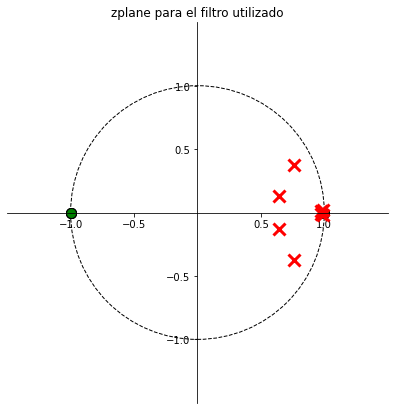

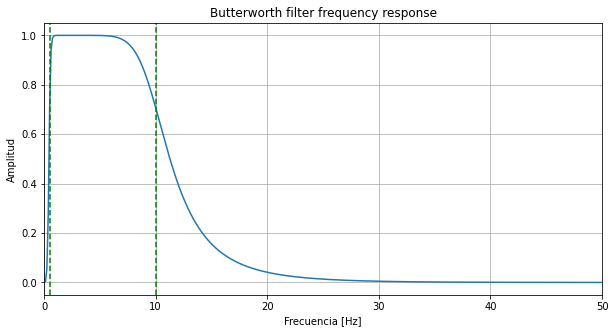

In [30]:
# Función de transferencia 
HPBanda = control.tf(numeradorPPG, denominadorPPG, 1/Fs)
print('HButter = ', HPBanda)

# Diagrama de polos 
cerosPPG, polosPPG, kPPG = zplane(numeradorPPG,denominadorPPG,filename="zplane para el filtro utilizado")


# Gráfico del filtro
wPPG, hPPG = signal.freqz(numeradorPPG, denominadorPPG)
plt.figure(figsize=[10,5])
plot_H(wPPG, hPPG,[wCorte1,wCorte2],Fs)


Se procede a observar las señales obtenidas antes y despues de aplicar los filtros para comparar los comportamientos de cada una. Para esto se realiza un acercamiento en una porción de la señal, ya que permite distinguir mejor las diferencias. Se observan tanto en tiempo como en frecuencia.

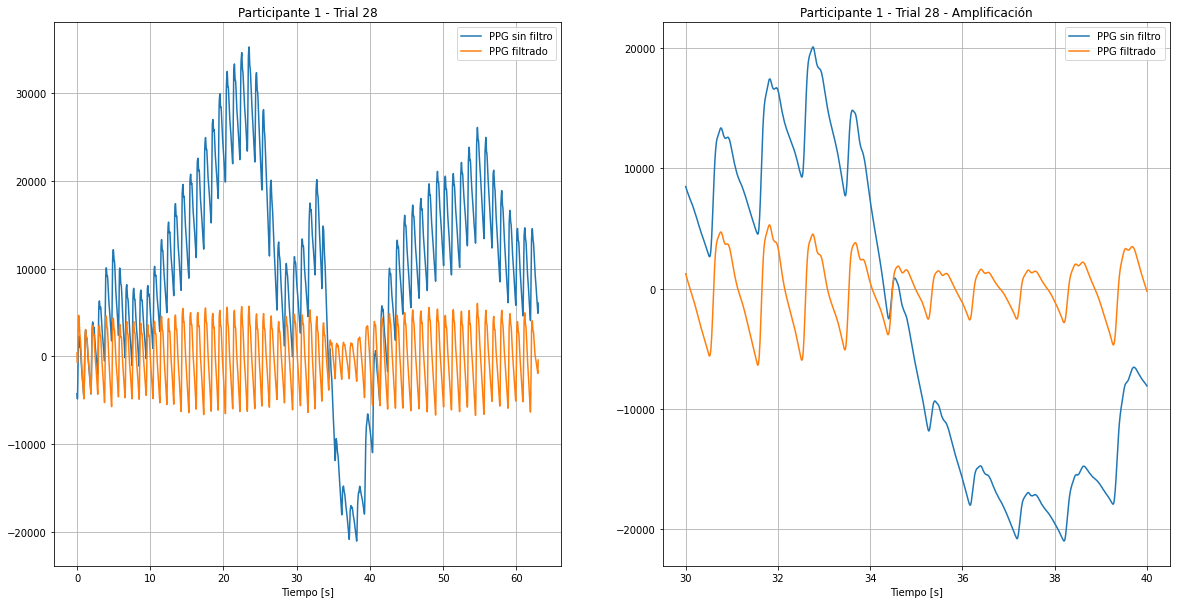

In [31]:
# en tiempo # ojo lo que comente arriba que dice para ver cual se comporta mejor
t1,t2 = 30*Fs,40*Fs

PPG0_n1 = PPG[0,n1,:]
PPGfiltrado0_n1 = PPGfiltrado[0,n1,:]

plt.figure(figsize=[20,10])
plt.subplot(121)
plt.plot(t,PPG0_n1,label='PPG sin filtro') # [participante9, trialn1, datos]
plt.plot(t,PPGfiltrado0_n1,label='PPG filtrado')
plt.title('Participante 1 - Trial ' + str(n1+1))
plt.legend()
plt.xlabel('Tiempo [s]')
plt.grid()

plt.subplot(122)
plt.plot(t[t1:t2],PPG0_n1[t1:t2],label='PPG sin filtro') # [participante9, trialn1, datos]
plt.plot(t[t1:t2],PPGfiltrado0_n1[t1:t2],label='PPG filtrado')
plt.title('Participante 1 - Trial ' + str(n1+1) + ' - Amplificación')
plt.legend()
plt.xlabel('Tiempo [s]')
plt.grid()


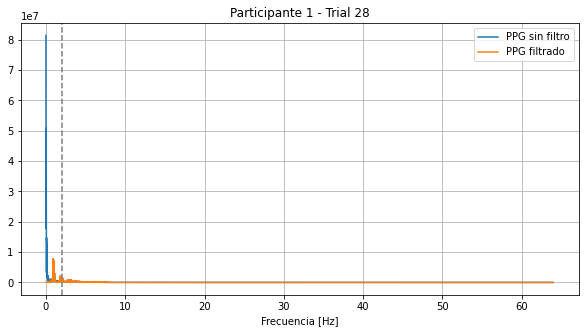

In [32]:
# en frecuencia
PPG0_n1fft = np.abs(np.fft.fft(PPG[0,n1,:]))
PPGfiltrado0_n1fft = np.abs(np.fft.fft(PPGfiltrado[0,n1,:]))

plt.figure(figsize=[10,5])
plt.plot(f[0:fmax], PPG0_n1fft[0:fmax], label = 'PPG sin filtro')
plt.plot(f[0:fmax], PPGfiltrado0_n1fft[0:fmax], label = 'PPG filtrado')
plt.axvline(wCorte, color = 'gray', linestyle = 'dashed')
plt.title('Participante 1 - Trial ' + str(n1+1))
plt.legend()
plt.xlabel('Frecuencia [Hz]')
plt.grid()
plt.show()

### EEG 
Observamos que las señales tenian aplicado un filtro pasa banda para las frecuencias de 4 a 45 Hz, pero que seguían presentando ruido que dificultaba su análisis. Considerando que la base de datos establece que los artefactos de EOG fueron removidos pero la técnica no esta explícita (la página web a la que referencian no está disponible), se optó por implementar un filtro adaptativo de Weiner con una configuración ANC (Adaptive Noise Cancellation) para llevarlo a cabo.  

Para esto se aplica la función lms_derivaciones, la cual implementa la función lms (explicada en la sección de Funciones) para cada derivación de EEG. En síntesis lo que se realiza es lo siguiente:

1. toma una derivación para todos los participantes y trials
2. recorre cada una de las señales 
3. toma la EOGtot correspondiente (dado por la combinación lineal de las señales de movimiento ocular vertical y horizonal con igual ponderación para cada una) como señal de referencia (deseada), y cada señal de EEG es la entrada y luego se define el valor a, a partir de la cual se calcula la constante de convergencia delta considerando la potencia y el orden del filtro L. 


Por último, para las señales de EEG, se consideraron los ritmos alfa (8-13Hz), beta (13-30Hz) y gamma (30-64Hz), y se calculó el periodograma para cada banda. Se tomaron las siguientes características: frecuencia dominante, densidad espectral de potencia en cada ritmo y la media. Estos datos fueron tomados a partir de cada uno de los canales de EEG.

Para el análisis se utilizaron únicamente las señales de los participantes 1 a 22, ya que más adelante en el trabajo se opta por eliminar los últimos 8 pacientes y sus registros.

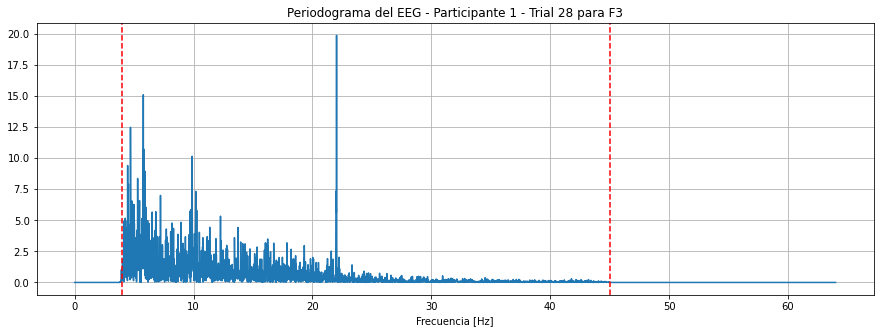

In [33]:
freqEEGs0, periodEEGs0 = scipy.signal.periodogram(f3EEG[0,n1,:], Fs, return_onesided=True)
plt.figure(figsize = (15,5))
plt.plot(freqEEGs0, periodEEGs0)
plt.axvline(4, color = 'red', linestyle = 'dashed')
plt.axvline(45, color = 'red', linestyle = 'dashed')
plt.title('Periodograma del EEG - Participante 1 - Trial ' + str(n1+1) + ' para F3')
plt.xlabel('Frecuencia [Hz]')
plt.grid()
plt.show()

In [34]:
# movimiento ocular ponderado total:
EOGtot = 0.5*(EOGh[0:cantParticipantesT,:,:]+EOGv[0:cantParticipantesT,:,:]) # le damos igual importancia

Para buscar el orden óptimo del filtro FIR se aplica el criterio de Akaike, el cual establece que dado un conjunto de modelos candidatos para los datos, el modelo preferido es el que tiene el valor mínimo en la fórmula de AIC, definida de la siguiente manera:

$AIC(k) = N \ln(\sigma_{error}^{\;2}) + 2\, k$ 

Donde 
* $k$ es el orden del filtro
* $N$ el largo de la señal
* $\sigma_{error}^{\;2}$ la varianza del error estimado 

In [35]:
## Criterio AIC
N = muestras0
entrada = f3EEG[0,3,:]
deseada = EOGtot[0,3,:]
k = np.arange(1, 30)
a = 0.25
Px = np.mean(entrada**2)
delta = a * (1/ (10*k*Px))

error_adap = [] # error cuadratico medio de wiener adaptativo
numerador_adap = []
complex_adap = []

for i in range(len(k)):
  b, y_, e = lms(entrada, deseada, k[i], delta[i])
  numerador_adap.append(b[0])
  y = scipy.signal.lfilter(b[0], 1, entrada)
  complex_adap.append(y)
  error_adap.append(np.sum((deseada - y)**2) / N)


AIC_adap = N*np.log(error_adap) + 2*k

min_adap_aic = np.where(AIC_adap == min(AIC_adap))[0][0]
min_adap = k[min_adap_aic]

print('El mínimo se encuentra en k =', str(min_adap))

El mínimo se encuentra en k = 17


Dado que se obtuvo una k de 17 aplicando el criterio de Akaike, se define con dicho valor el orden L de la función lms_derivaciones. 

In [36]:
EEGsOut = np.zeros([8,cantParticipantesT,trials0,muestras0]) 
EEGsOut[0,:,:,:] = lms_derivaciones(entradas=f3EEG[0:cantParticipantesT,:,:], deseadas = EOGtot, a=0.25, L=min_adap)
EEGsOut[1,:,:,:] = lms_derivaciones(entradas=f4EEG[0:cantParticipantesT,:,:], deseadas = EOGtot, a=0.25, L=min_adap)
EEGsOut[2,:,:,:] = lms_derivaciones(entradas=f7EEG[0:cantParticipantesT,:,:], deseadas = EOGtot, a=0.25, L=min_adap)
EEGsOut[3,:,:,:] = lms_derivaciones(entradas=f8EEG[0:cantParticipantesT,:,:], deseadas = EOGtot, a=0.25, L=min_adap)
EEGsOut[4,:,:,:] = lms_derivaciones(entradas=t7EEG[0:cantParticipantesT,:,:], deseadas = EOGtot, a=0.25, L=min_adap)
EEGsOut[5,:,:,:] = lms_derivaciones(entradas=t8EEG[0:cantParticipantesT,:,:], deseadas = EOGtot, a=0.25, L=min_adap)
EEGsOut[6,:,:,:] = lms_derivaciones(entradas=p7EEG[0:cantParticipantesT,:,:], deseadas = EOGtot, a=0.25, L=min_adap)
EEGsOut[7,:,:,:] = lms_derivaciones(entradas=p8EEG[0:cantParticipantesT,:,:], deseadas = EOGtot, a=0.25, L=min_adap)

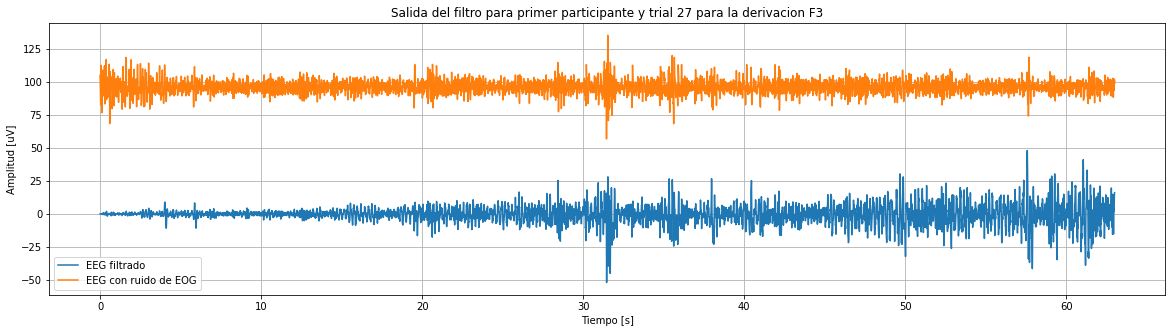

In [37]:
plt.figure(figsize=[20,5])
plt.plot(t,EEGsOut[0,0,n1,:], label = 'EEG filtrado')
plt.plot(t,f3EEG[0,n1,:]+max(EEGsOut[0,0,n1,:])*2, label = 'EEG con ruido de EOG')
plt.ylabel('Amplitud [uV]') 
plt.xlabel('Tiempo [s]')
plt.title('Salida del filtro para primer participante y trial '+str(n1)+' para la derivacion F3')
plt.legend()
plt.grid()
plt.show()

Luego de aplicarle el filtro adaptativo para la cancelación del ruido de EOG pueden haberse modificado los componentes frecuenciales, ya que es un filtro que trabaja en tiempo, por lo que se procede a aplicarle el filtro pasa bandas que tenía originalmente desde el preprocesado de la base de datos.

In [38]:
wCorte1EEG = 4
wCorte2EEG = 45
ordenEEG = 5

numeradorEEG, denominadorEEG = butter(ordenEEG, [wCorte1EEG, wCorte2EEG], btype = 'band', fs = Fs)

EEGfiltrado = signal.filtfilt(numeradorEEG, denominadorEEG, EEGsOut[0,0,3,:])

HButter =  
                             0.1408 z^10 - 0.7042 z^8 + 1.408 z^6 - 1.408 z^4 + 0.7042 z^2 - 0.1408
--------------------------------------------------------------------------------------------------------------------------------
z^10 - 2.431 z^9 + 1.221 z^8 + 0.4507 z^7 + 0.7367 z^6 - 1.247 z^5 - 0.05084 z^4 + 0.2733 z^3 + 0.1184 z^2 - 0.05047 z - 0.01963

dt = 0.0078125



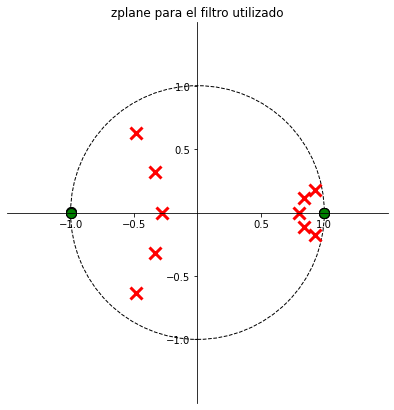

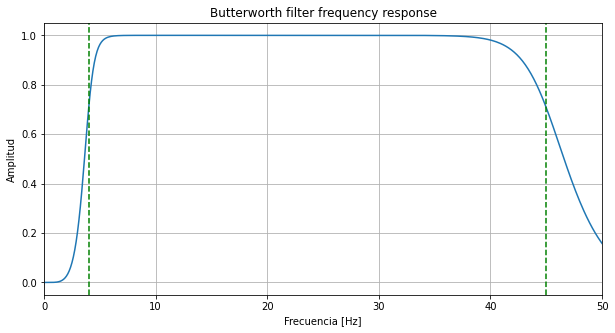

In [39]:
# Función de transferencia 
HPBandaEEG = control.tf(numeradorEEG, denominadorEEG, 1/Fs)
print('HButter = ', HPBandaEEG)

# Diagrama de polos 
cerosEEG, polosEEG, kEEG = zplane(numeradorEEG,denominadorEEG,filename="zplane para el filtro utilizado")


# Gráfico del filtro
wEEG, hEEG = signal.freqz(numeradorEEG, denominadorEEG)
plt.figure(figsize=[10,5])
plot_H(wEEG, hEEG,[wCorte1EEG,wCorte2EEG],Fs)


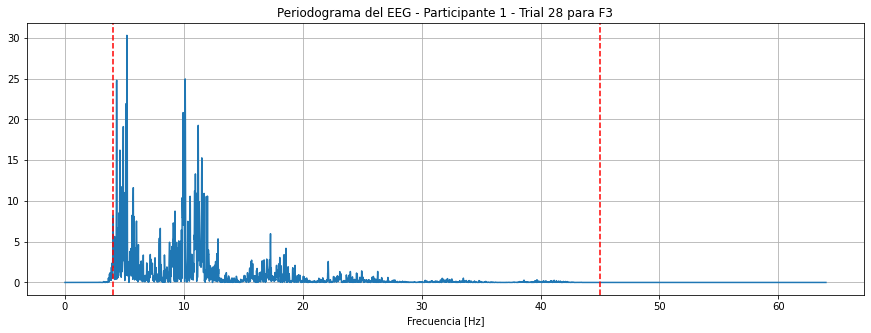

In [40]:
freqEEGs01, periodEEGs01 = scipy.signal.periodogram(EEGfiltrado, Fs, return_onesided=True)
plt.figure(figsize = (15,5))
plt.plot(freqEEGs01, periodEEGs01)
plt.axvline(4, color = 'red', linestyle = 'dashed')
plt.axvline(45, color = 'red', linestyle = 'dashed')
plt.title('Periodograma del EEG - Participante 1 - Trial ' + str(n1+1) + ' para F3')
plt.xlabel('Frecuencia [Hz]')
plt.grid()
plt.show()

In [41]:
for deriv in range(len(EEGsOut)):
  EEGfiltrado_deriv = signal.filtfilt(numeradorEEG, denominadorEEG, EEGsOut[deriv,:,:,:])
  EEGsOut[deriv,:,:,:] = EEGfiltrado_deriv

## Extracción de características


### Señales periféricas

##### Funciones

Se define la función que obtiene la frecuencia dominante de una señal a partir de su periodograma, para cada uno de los trials y para cada participante. Es el pico máximo que se obtiene a partir de la señal en frecuencia.

In [42]:
def freqDom(periodog, freqPeriodog, cantP, cantTrials):
  frecuenciaDominante = np.zeros([cantP, cantTrials])
  for part in range(cantP):
    for trial in range(cantTrials):
      donde = np.where(periodog[part,trial,:] == np.max(periodog[part,trial,:]))[0] # pedimos que sea la potencia maxima en ese caso
      if len(donde)>1:
        donde = donde[0]
      frecuenciaDominante[part,trial] = freqPeriodog[donde] # ponemos la frecuencia dominante
  return frecuenciaDominante

In [43]:
def potenciaBandasEq(periodog, freqPeriodog, FminBanda, FmaxBanda, numeroBandas, cantP, cantTrials):
  potenciaB = np.zeros([cantP,cantTrials,numeroBandas])

  dondeFmax = np.where(freqPeriodog==FmaxBanda)[0]
  if dondeFmax.shape[0] == 0: # salva que no este el valor exacto de Fmax
    change = freqPeriodog.copy()
    change[change>FmaxBanda]=1
    change[change<=FmaxBanda]=0
    dondeFmax = np.where(change==1)[0][0]

  dondeFmin = np.where(freqPeriodog==FminBanda)[0]
  if dondeFmin.shape[0] == 0: # salva que no este el valor exacto de Fmin
    change = freqPeriodog.copy()
    change[change>FminBanda]=1
    change[change<=FminBanda]=0
    dondeFmin = np.where(change==1)[0][0]
  anchoBandas = int(np.round((dondeFmax-dondeFmin)/numeroBandas)) # intervalos de las bandas

  for part in range(cantP):
    for trial in range(cantTrials):
      for nBanda in range(numeroBandas):
        inicio = int(nBanda*anchoBandas + dondeFmin)
        fin = int((nBanda+1)*anchoBandas + dondeFmin)
        if fin > dondeFmax:
          fin = int(dondeFmax)
        banda = periodog[part, trial, :][inicio:fin]
        potenciaB[part,trial,nBanda] = np.mean(banda)


  return potenciaB

#### Periodograma: frecuencia dominante 

Se realizó el periodograma de la señal GSR, PPG y TMP, y se buscó su máximo, con el fin de encontrar la frecuencia dominante de cada señal.


In [44]:
freqGSR, periodogramaGSR = scipy.signal.periodogram(GSRfiltrado, Fs)
freqPPG, periodogramaPPG = scipy.signal.periodogram(PPGfiltrado, Fs)
freqTMP, periodogramaTMP = scipy.signal.periodogram(TMPfiltrado, Fs)

##### Frecuencia Dominante

In [45]:
# calculo de la frecuencia dominante en cada uno de los casos
freqGSR_dom = freqDom(periodogramaGSR, freqGSR, cantParticipantes, trials0)
freqPPG_dom = freqDom(periodogramaPPG, freqPPG, cantParticipantes, trials0)
freqTMP_dom = freqDom(periodogramaTMP, freqTMP, cantParticipantes, trials0)


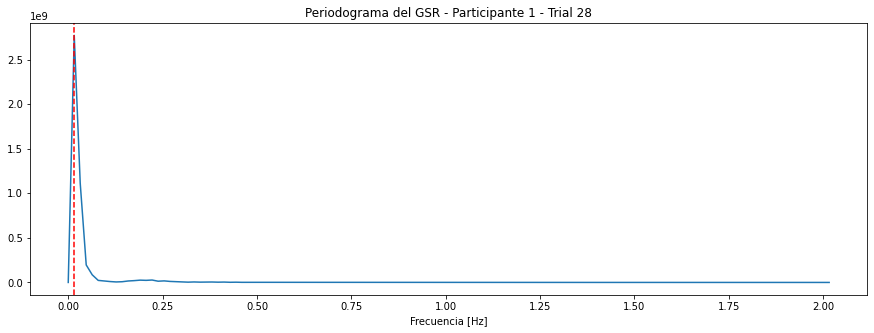

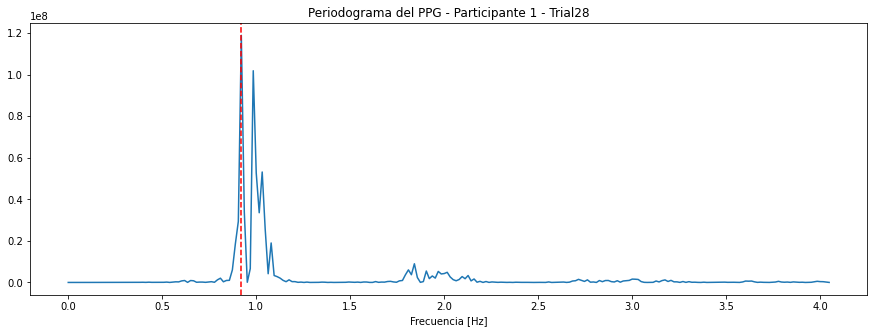

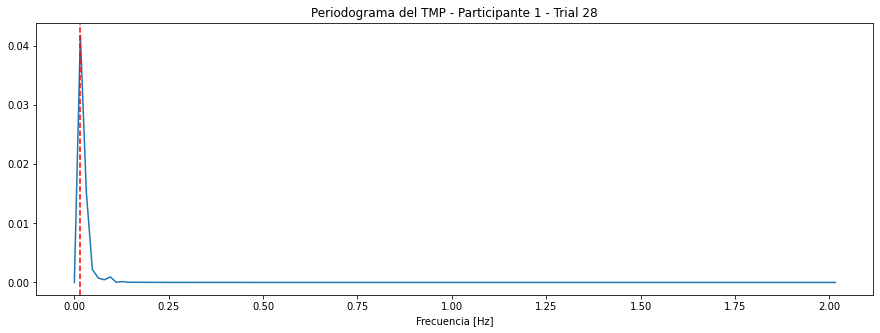

In [46]:
plt.figure(figsize = (15,5))
plt.plot(freqGSR[0:Fs], periodogramaGSR[0,n1,:][0:Fs])
plt.axvline(freqGSR_dom[0,n1], color = 'red', linestyle = 'dashed')
plt.title('Periodograma del GSR - Participante 1 - Trial ' + str(n1+1))
plt.xlabel('Frecuencia [Hz]')
plt.show()

plt.figure(figsize = (15,5))
plt.plot(freqPPG[0:2*Fs], periodogramaPPG[0,n1,:][0:2*Fs])
plt.axvline(freqPPG_dom[0,n1], color = 'red', linestyle = 'dashed')
plt.title('Periodograma del PPG - Participante 1 - Trial' + str(n1+1))
plt.xlabel('Frecuencia [Hz]')
plt.show()

plt.figure(figsize = (15,5))
plt.plot(freqTMP[0:Fs], periodogramaTMP[0,n1,:][0:Fs])
plt.axvline(freqTMP_dom[0,n1], color = 'red', linestyle = 'dashed')
plt.title('Periodograma del TMP - Participante 1 - Trial ' + str(n1+1))
plt.xlabel('Frecuencia [Hz]')
plt.show()


#### Ritmo cardíaco a partir de PPG - Promedio y desvío estándar 


Inicialmente se observa la señal filtrada obtenida a partir de PPG. Mediante el análisis de la distancia entre máximos locales se puede obtener el ritmo cardíaco. 

No handles with labels found to put in legend.


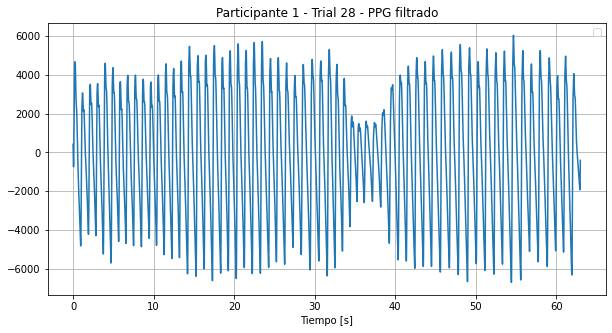

In [47]:
plt.figure(figsize=(10,5))
plt.plot(t, PPGfiltrado[0,n1,:])
plt.title('Participante 1 - Trial ' + str(n1+1) + ' - PPG filtrado')
plt.legend()
plt.xlabel('Tiempo [s]')
plt.grid()
plt.show()

Para ello, primero se implementa una funcion de scipy.signal, find_peaks para determinar los máximos que tiene la señal. Se entregan los parámetros que se observan a continuación para se tomen únicamente los maximos marcados, obviando los máximos intermedios. 

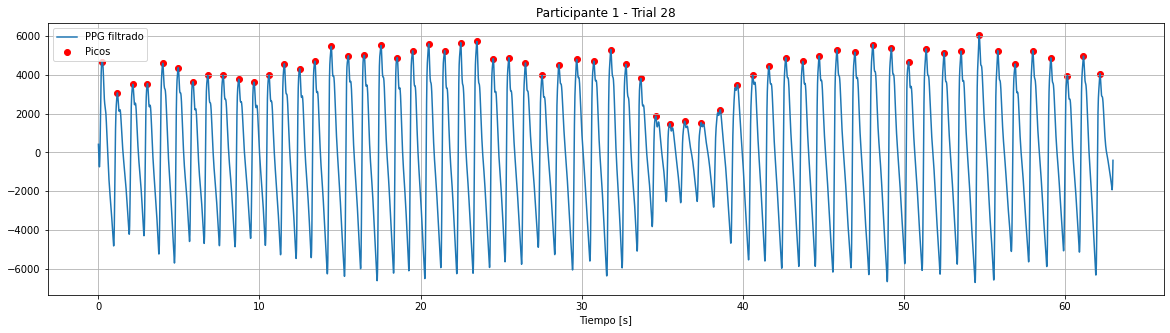

In [48]:
funcion = PPGfiltrado[0,n1,:]
FPeaks = scipy.signal.find_peaks(funcion,height= 0.1, distance = muestras0/Fs)[0] 

plt.figure(figsize=(20,5))
plt.plot(t, funcion, label = 'PPG filtrado')
plt.scatter(t[FPeaks],funcion[FPeaks], label = 'Picos', color = 'red')
plt.title('Participante 1 - Trial ' + str(n1+1))
plt.legend()
plt.xlabel('Tiempo [s]')
plt.grid()
plt.show()

Una vez que se lograron observar los picos ubicados de manera correcta, se realizó para cada uno de los participantes y para cada trial. En el DataFrame se observan los participantes, el trial y el promedio y desvío estandar del ritmo cardíaco en cada uno de los casos.

In [49]:
ppg_filtrado = PPGfiltrado.copy()
dfRitmoCardiaco = pd.DataFrame(columns=['Participante', 'Trial', 'Promedio RC', 'Desvio Estandar RC'])
j = 0
for part in range(cantParticipantes):

  for trial in range(trials0):
    dato_trial = []
    PPG_trial = ppg_filtrado[part,trial,:]
    FP_trial = scipy.signal.find_peaks(PPG_trial,height= 0.1, distance =  muestras0/Fs)[0] # esto hay que cambiarlo!

    for i in range(len(FP_trial)-1):
      deltat = t[FP_trial[i+1]]-t[FP_trial[i]]
      deltaf = 60/deltat
      dato_trial.append(deltaf)

    promediof = np.mean(dato_trial)
    desviof = np.std(dato_trial)

    dfRitmoCardiaco.loc[j] = [part,trial, promediof, desviof]
    j+=1

In [50]:
dfRitmoCardiaco

Participante  Trial  Promedio RC  Desvio Estandar RC
0              0.0    0.0    65.362497            4.412721
1              0.0    1.0    59.228775            2.932831
2              0.0    2.0    66.281532            5.169828
3              0.0    3.0    59.621470            3.616412
4              0.0    4.0    62.964579            4.755257
...            ...    ...          ...                 ...
1275          31.0   35.0    87.054363           21.914069
1276          31.0   36.0    86.504009           21.906635
1277          31.0   37.0    84.512542           20.899731
1278          31.0   38.0    87.179312           23.221855
1279          31.0   39.0    87.727688           22.110888

[1280 rows x 4 columns]

In [51]:
print('Ritmo cardiaco promedio del primer participante a lo largo de los distintos trials:')
dfRitmoCardiaco.loc[dfRitmoCardiaco['Participante']==0, ['Trial', 'Promedio RC']].head()

Ritmo cardiaco promedio del primer participante a lo largo de los distintos trials:


Trial  Promedio RC
0    0.0    65.362497
1    1.0    59.228775
2    2.0    66.281532
3    3.0    59.621470
4    4.0    62.964579

In [52]:
print('Ritmo cardiaco promedio de los distintos participantes para el trial ' + str(n1+1) + ':' )
dfRitmoCardiaco.loc[dfRitmoCardiaco['Trial']==n1, ['Participante' , 'Promedio RC']].head()

Ritmo cardiaco promedio de los distintos participantes para el trial 28:


Participante  Promedio RC
27            0.0    59.350456
67            1.0    70.477130
107           2.0    80.073555
147           3.0    61.657506
187           4.0    74.846242

Una vez obtenidos los ritmos cardíacos promedio se opto por graficar los mismos en forma de barras para poder obtener una mejor visualización de los resultados. 



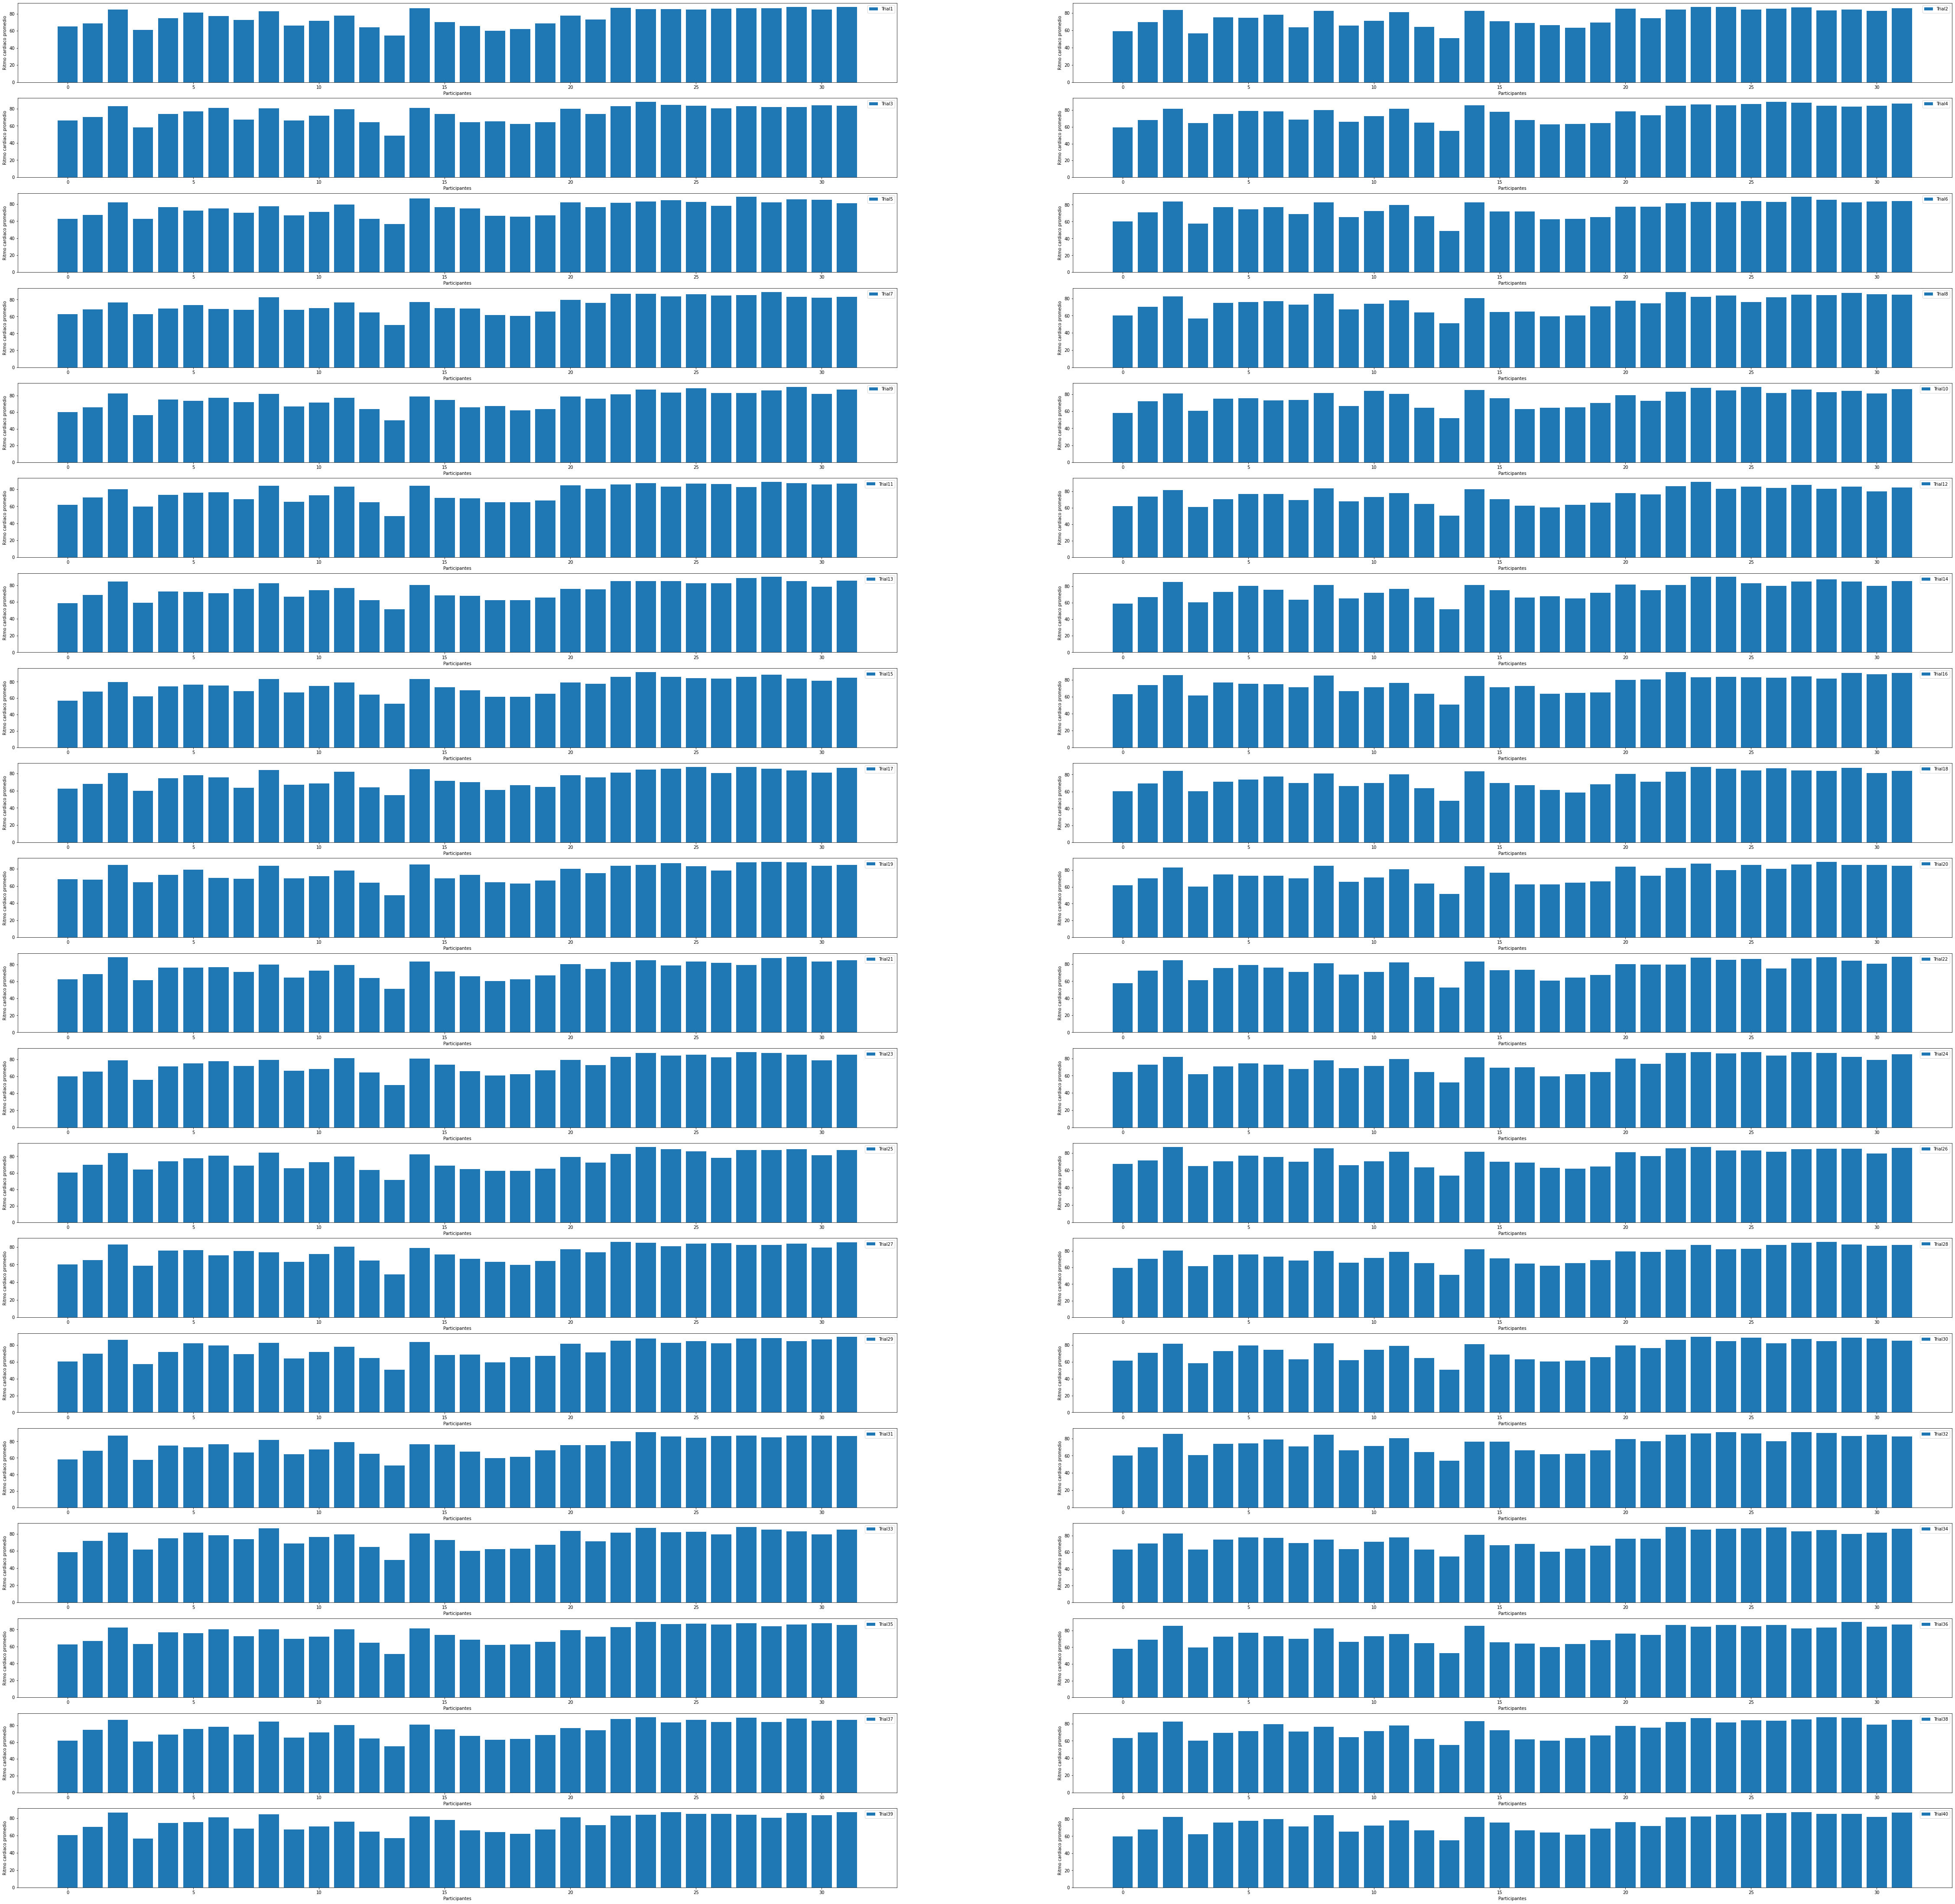

In [53]:
b = int(trials0/2)
plt.figure(figsize=(80,80))
for a in range(trials0):
  plt.subplot(b,2,a+1)
  ejeX = np.array(dfRitmoCardiaco.loc[dfRitmoCardiaco['Trial']==a, 'Participante'])
  ejeY = np.array(dfRitmoCardiaco.loc[dfRitmoCardiaco['Trial']==a, 'Promedio RC'])
  titulo = 'Trial' + str(a+1)
  plt.bar(ejeX, ejeY, label = titulo)
  plt.legend()
  plt.xlabel('Participantes')
  plt.ylabel('Ritmo cardiaco promedio')

plt.show()

A partir del participante número 23 podemos notar que la frecuencia cardíaca en todos los trials es mucho mas alta en relación al resto de los datos. Tambien ocurre en el caso del participante 6.

Por lo tanto, se procede a comparar las señales para estos casos.

Iniciamos observando las señales del participante 6 con los numeros aleatorios de trial n1 y n2 anteriormente utilizados. A su vez, se tomara otro participante para compararlos.

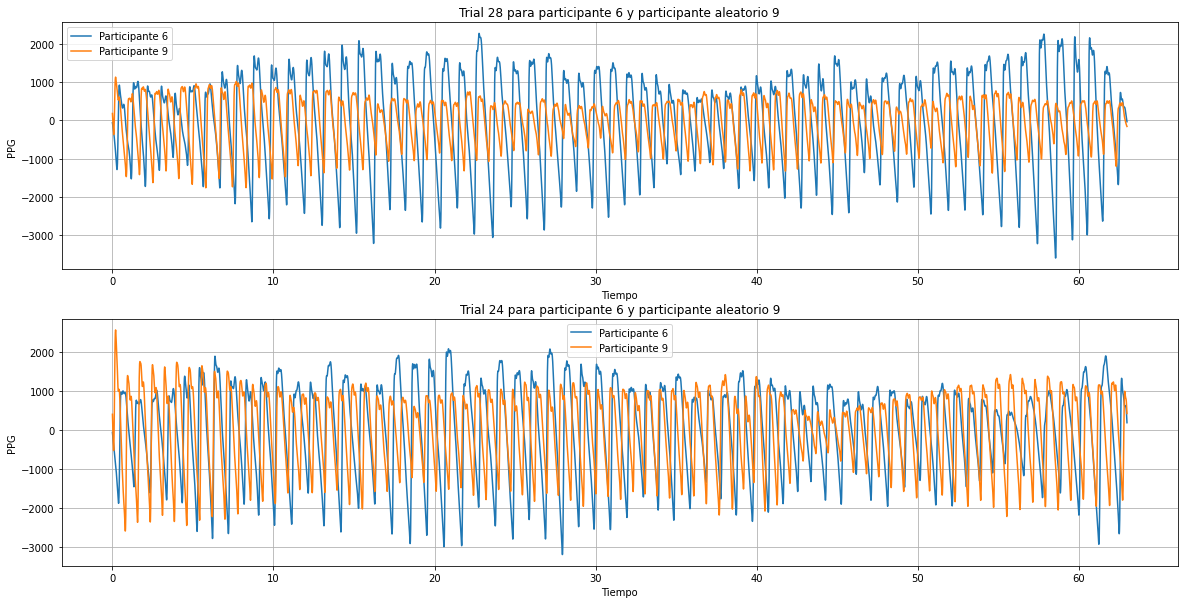

In [54]:
pA = int(random.choice(range(0,cantParticipantes))) # participante aleatorio

ppg_6 = PPGfiltrado[3,:,:] # PPG del participante 6
ppg_pA = PPGfiltrado[pA,:,:]


plt.figure(figsize=[20,10])

plt.subplot(2,1,1)

# trial n1
plt.plot(t, ppg_6[n1,:], label = 'Participante ' + str(6))
plt.plot(t, ppg_pA[n1,:], label = 'Participante ' + str(pA+1))
plt.title('Trial '+str(n1+1)+' para participante 6 y participante aleatorio '+str(pA+1))
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('PPG')
plt.grid()

plt.subplot(2,1,2)

# trial n2
plt.plot(t, ppg_6[n2,:], label = 'Participante ' + str(6))
plt.plot(t, ppg_pA[n2,:], label = 'Participante ' + str(pA+1))
plt.title('Trial '+str(n2+1)+' para participante 6 y participante aleatorio '+str(pA+1))
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('PPG')
plt.grid()

plt.show()

Como se puede apreciar, la forma de la señal parece correcta, aunque la amplitud de la señal del participante 6 es mayor. Además, se puede observar si para el caso del participante 6 se estan tomando bien los picos, ya que de ser así la variación de amplitud no presentaría problema para detectar el ritmo cardíaco. 

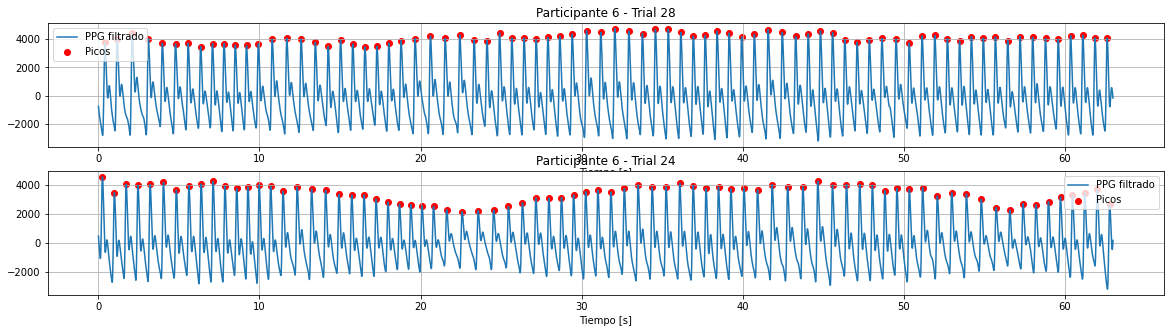

In [55]:
part6n1 = PPGfiltrado[5,n1,:]
FPeaks6n1 = scipy.signal.find_peaks(part6n1,height= 0.1, distance = muestras0/Fs)[0] 
part6n2 = PPGfiltrado[5,n2,:]
FPeaks6n2 = scipy.signal.find_peaks(part6n2,height= 0.1, distance = muestras0/Fs)[0] 

plt.figure(figsize=(20,5))
plt.subplot(211)
plt.plot(t, part6n1, label = 'PPG filtrado')
plt.scatter(t[FPeaks6n1],part6n1[FPeaks6n1], label = 'Picos', color = 'red')
plt.title('Participante 6 - Trial ' + str(n1+1))
plt.legend()
plt.grid()
plt.xlabel('Tiempo [s]')

plt.subplot(212)
plt.plot(t, part6n2, label = 'PPG filtrado')
plt.scatter(t[FPeaks6n2],part6n2[FPeaks6n2], label = 'Picos', color = 'red')
plt.title('Participante 6 - Trial ' + str(n2+1))
plt.legend()
plt.grid()
plt.xlabel('Tiempo [s]')

plt.show()

Por otro lado, para observar que ocurre en los participantes desde el 24 tomamos un participante aleatorio de este grupo y uno del 1 al 23 para poder comparar las señales.

Observar los participantes del 24 en adelante con todos sus trials, no es posible ya que se vuelve muy engorrosa la visualización de todas las señales al mismo tiempo.

Entonces, se utilizan n1 y n2, ya calculadas para trials aleatorios. Se procede a tomar g1 y g2, para un participante del grupo 1 (hasta 23) y un participante del grupo 2 (desde 24), respectivamente.

In [56]:
cantP1 = 23
cantP2 = cantParticipantes - cantP1
participantesgrupo1 = np.linspace(0,cantP1-1,cantP1)
participantesgrupo2 = np.linspace(cantP1,cantParticipantes-1,cantP2)
g1 = int(random.choice(participantesgrupo1))
g2 = int(random.choice(participantesgrupo2))
PPGg1_n1 = PPGfiltrado[g1,n1,:]
PPGg1_n2 = PPGfiltrado[g1,n2,:]

PPGg2_n1 = PPGfiltrado[g2,n1,:]
PPGg2_n2 = PPGfiltrado[g2,n2,:]

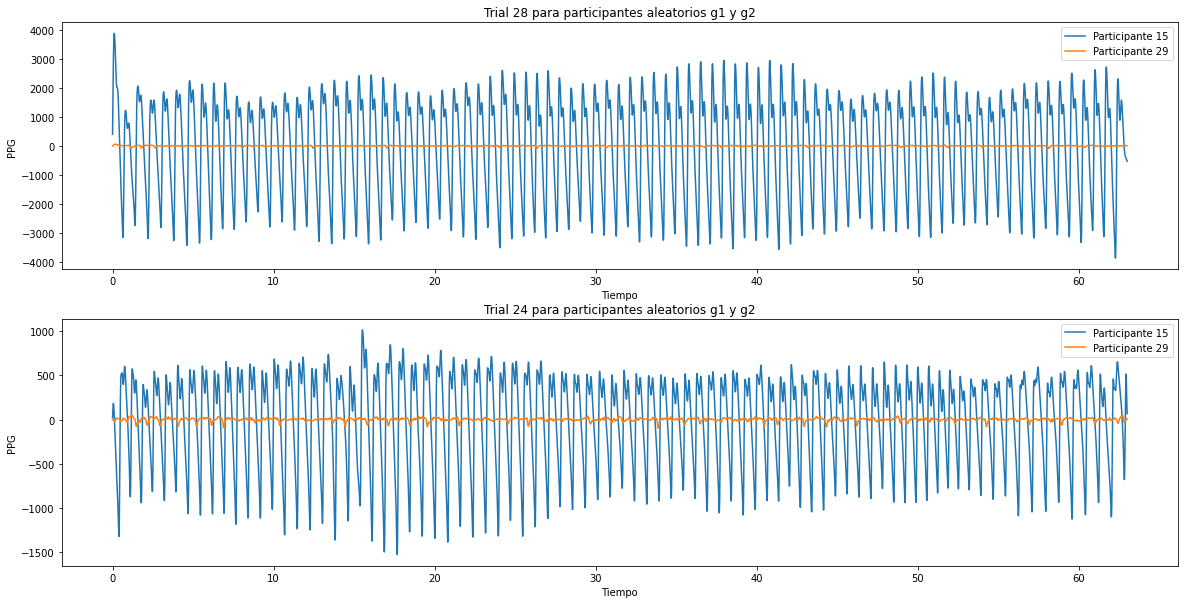

In [57]:
plt.figure(figsize=[20,10])

plt.subplot(2,1,1)

# trial n1
plt.plot(t, PPGg1_n1, label = 'Participante ' + str(g1+1))
plt.plot(t, PPGg2_n1, label = 'Participante ' + str(g2+1))
plt.title('Trial '+str(n1+1)+' para participantes aleatorios g1 y g2')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('PPG')

plt.subplot(2,1,2)

# trial n2
plt.plot(t, PPGg1_n2, label = 'Participante ' + str(g1+1))
plt.plot(t, PPGg2_n2, label = 'Participante ' + str(g2+1))
plt.title('Trial '+str(n2+1)+' para participantes aleatorios g1 y g2')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('PPG')

plt.show()

In [58]:

dfg2 = pd.DataFrame(columns = ['Participantes', 'Trial', 'Maximo+minimo'])
j = 0
for a in range(23,cantParticipantes):
  for i in range(trials0):
    datas = PPGfiltrado[a,i,:]
    if np.min(datas)<0:
      valor = np.max(datas)+np.abs(np.min(datas))
    else:
      valor = np.max(datas)-np.abs(np.min(datas))
    dfg2.loc[j] = [a,i,valor]
    j+=1

maximog2 = np.max(dfg2['Maximo+minimo']) # mal redactado el print
print('Promedio de maxima amplitud de los participantes mayores a 24 (todos los trials juntos):',maximog2)


dfg1 = pd.DataFrame(columns = ['Participantes', 'Trial', 'Maximo+minimo'])
j = 0
for a in range(23):
  for i in range(trials0):
    datas = PPGfiltrado[a,i,:]
    if np.min(datas)<0:
      valor = np.max(datas)+np.abs(np.min(datas))
    else:
      valor = np.max(datas)-np.abs(np.min(datas))
    dfg1.loc[j] = [a,i,valor]
    j+=1

maximog1 = np.max(dfg1['Maximo+minimo'])
print('Promedio de maxima amplitud de los participantes menores a 23 (todos los trials juntos):',maximog1)

Promedio de maxima amplitud de los participantes mayores a 24 (todos los trials juntos): 644.8374148263047
Promedio de maxima amplitud de los participantes menores a 23 (todos los trials juntos): 361128.06310384744


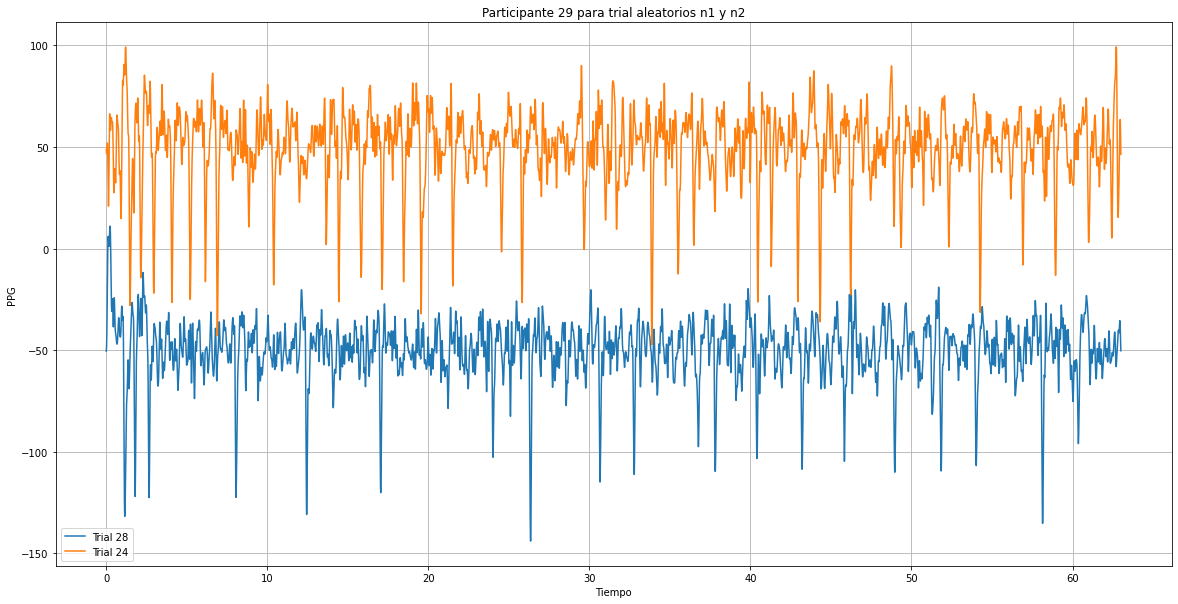

In [59]:
plt.figure(figsize=[20,10])
plt.plot(t, PPGg2_n1 - 50, label = 'Trial ' + str(n1+1))
plt.plot(t, PPGg2_n2 + 50, label = 'Trial ' + str(n2+1))
plt.title('Participante '+str(g2+1)+' para trial aleatorios n1 y n2')
plt.legend()
plt.grid()
plt.xlabel('Tiempo')
plt.ylabel('PPG')
plt.show()

Se observa gráficamente que , además de que la amplitud de las señales de los participantes del grupo 2 es mucho menor, la localización de los picos para estos casos posiblemente sean menos precisa. 

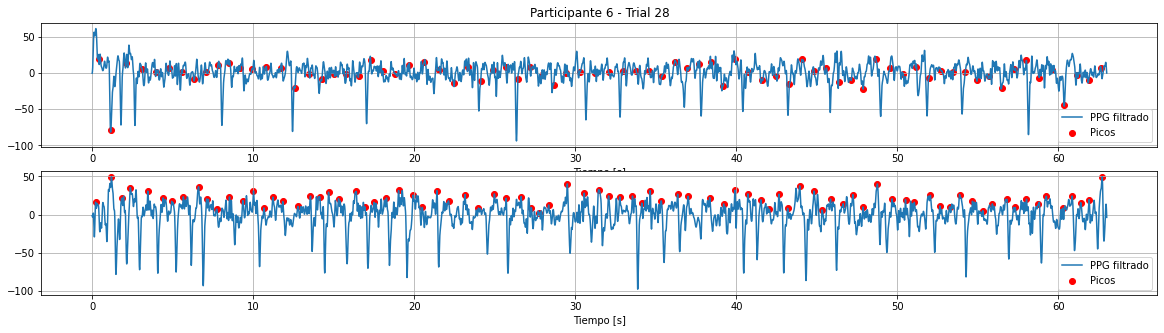

In [60]:
partg2n1 = PPGfiltrado[g2,n1,:]
FPeaksg2n1 = scipy.signal.find_peaks(part6n1,height= 0.01, distance = muestras0/Fs)[0] 
partg2n2 = PPGfiltrado[g2,n2,:]
FPeaksg2n2 = scipy.signal.find_peaks(partg2n2,height= 0.01, distance = muestras0/Fs)[0] 

plt.figure(figsize=(20,5))
plt.title('Participante ' + str(g2+1)+' - Trial ' + str(n2+1))

plt.subplot(211)
plt.plot(t, partg2n1, label = 'PPG filtrado')
plt.scatter(t[FPeaksg2n1],partg2n1[FPeaksg2n1], label = 'Picos', color = 'red')
plt.title('Participante 6 - Trial ' + str(n1+1))
plt.legend()
plt.grid()
plt.xlabel('Tiempo [s]')

plt.subplot(212)
plt.plot(t, partg2n2, label = 'PPG filtrado')
plt.scatter(t[FPeaksg2n2],partg2n2[FPeaksg2n2], label = 'Picos', color = 'red')

plt.legend()
plt.grid()
plt.xlabel('Tiempo [s]')

plt.show()

Se observa entonces que las amplitudes de los registros a partir del participante 24, tienen menor amplitud y, además, no se tienen la forma característica de la señal PPG. En algunos casos los picos no están en el lugar correcto con el mismo procesamiento de información que en los primeros 23 participantes. Esto puede deberse a errores en la adquisicion de las señales.

Se considera que puede haber tomado relevancia el hecho de que los datos se registraron en dos lugares distintos. Los participantes 1-22 se encontraban en Twente y los participantes 23-32 en Ginebra. Debido a una revisión diferente del hardware, hay algunas diferencias menores en el formato. En primer lugar, el orden de los canales de EEG es diferente en los dos lugares. En segundo lugar, la medida de GSR tiene un formato diferente para cada ubicación. Si bien son diferencias que en teoría se pueden corregir, es posible que haya otras que no fueron detectadas que podrían justificarse de otra manera. Por lo tanto, optamos por eliminar los registros de los participantes 23-32 para garantizar la uniformidad de los datos, teniendo en cuenta que la diferencia en la cantidad de participantes no es notable.



#### GSR y TMP: promedio y derivada
Se buscan los valores del promedio y el promedio de la derivada de las señales de GSR y TMP, como sugiere el paper que desarrolla la base de datos. Son características que nos resultaron intuitivas para analizar las señales, son fáciles de obtener y brindan información relevante de cada una, ya que a partir de estas se puede apreciar la magnitud del cambio en su valor.

##### Funciones

In [61]:
def derivadaSenal(senal,fs):
    dt = 1/fs
    derivada = np.zeros_like(senal)
    derivada[0:-1] = np.diff(senal) # out[i] = a[i+1] - a[i], da un valor menos la funcion
    derivada[-1] = senal[-1]-senal[-2]
    derivada = derivada/dt

    return derivada

##### Promedio y promedio de derivada

In [62]:
dfGSR = pd.DataFrame(columns = ['Participantes', 'Trials', 'Promedio', 'Promedio derivada'])
dfTMP = pd.DataFrame(columns = ['Participantes', 'Trials', 'Promedio', 'Promedio derivada'])
j=0
for a in range(cantParticipantes):
  for i in range(trials0):

    # promedio de las señales
    promedioGSR = np.mean(GSRfiltrado[a,i,:])
    promedioTMP = np.mean(TMPfiltrado[a,i,:])

    # derivada de las señales
    derivadaGSR = derivadaSenal(senal=GSRfiltrado[a,i,:] ,fs=Fs)
    derivadaTMP = derivadaSenal(senal=TMPfiltrado[a,i,:] ,fs=Fs)

    # promedio de la derivada
    promGSRdt = np.mean(derivadaGSR)
    promTMPdt = np.mean(derivadaTMP)
    dfGSR.loc[j]=[a,i,promedioGSR,promGSRdt]
    dfTMP.loc[j]=[a,i,promedioTMP, promTMPdt]

    j+=1

In [63]:
dfGSR.head()

Participantes  Trials      Promedio  Promedio derivada
0            0.0     0.0   1716.458501         -12.005183
1            0.0     1.0  -4327.267869        -210.375599
2            0.0     2.0 -43738.302865       -1420.021372
3            0.0     3.0   9473.533352         287.376934
4            0.0     4.0   5486.050317         294.238031

In [64]:
dfTMP.head()

Participantes  Trials  Promedio  Promedio derivada
0            0.0     0.0 -0.042335          -0.001638
1            0.0     1.0 -0.016863          -0.001077
2            0.0     2.0 -0.029897          -0.002437
3            0.0     3.0 -0.016429           0.000206
4            0.0     4.0 -0.041216          -0.000799

### EEG
Se tomaron 8 derivaciones del total.

##### Funciones

In [65]:
def frecuenciaDom(period,freq):
  donde = np.where(period==np.max(period))[0][0]
  fdom = freq[donde]
  return fdom

##### Frecuencia dominante - Periodograma de los EEG 
Mediante el uso de la FFT, la señal de EEG puede mapearse desde el dominio del tiempo al dominio de la frecuencia. El espectro de frecuencia de la señal es reconocido por descomponer la señal en su correspondiente sinusoidal de diferentes frecuencias.

In [66]:
a, b, c, d = EEGsOut.shape
freqEEGs = np.zeros([a, b, c, int(d/2+1)])
periodEEGs = np.zeros([a, b, c, int(d/2+1)])
freqDomEEGs = np.zeros([a, cantParticipantesT, trials0])
for i in range(len(EEGsOut)):
  senal = EEGsOut[i]
  freqEEGs_i,periodEEGs_i = scipy.signal.periodogram(senal, Fs, return_onesided=True)
  periodEEGs[i,:,:,:] = periodEEGs_i
  freqEEGs[i,:,:,:] = freqEEGs_i
  freqDomEEGs[i] = freqDom(periodEEGs_i, freqEEGs_i, cantParticipantesT, trials0)

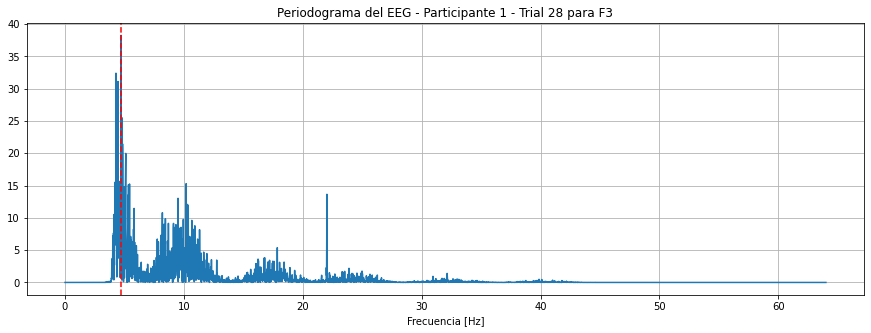

In [67]:
plt.figure(figsize = (15,5))
plt.plot(freqEEGs[0,0,n1], periodEEGs[0,0,n1])
plt.axvline(freqDomEEGs[0,0,n1], color = 'red', linestyle = 'dashed')
plt.title('Periodograma del EEG - Participante 1 - Trial ' + str(n1+1) + ' para F3')
plt.xlabel('Frecuencia [Hz]')
plt.grid()
plt.show()

##### Frecuencia dominante para ritmos del EEG

Se procede a buscar la frecuencia dominante y la media para cada uno de los ritmos de los EEG. Se observan los ritmos:
* alpha: 8-13 hz
* beta = 13-30 hz
* gamma = 30-64 hz - el vector no llega a 64 porque se realiza un filtado de las señales en su preprocesamiento, por lo que se toma el último valor que ronda los 45 Hz.

In [68]:
begin_alpha = np.where(f==8)[0][0]
begin_beta = np.where(f==13)[0][0]
begin_gamma = np.where(f==30)[0][0]
fmax = np.max(f)
if fmax<=64:  
  end_gamma = np.where(f==fmax)[0][0]
else:
  end_gamma = np.where(f==64)[0][0]

dfEEGDominante = pd.DataFrame( )
dfEEGMedias = pd.DataFrame( )
dfEEGDominante = dfRitmoCardiaco.loc[:,['Participante','Trial']].copy()
dfEEGMedias = dfRitmoCardiaco.loc[:,['Participante','Trial']].copy()


# para todos los participantes y trials ver EEG en frecuencia ==> periodograma
for deriv in range(len(EEGsOut)): # orden en el que se guardaron en EEGsOut

  # matrices para la derivacion que estoy viendo
  cols_i = ['Participante','Trial', 'Freq Dom Tot ' + str(deriv), 'Freq Dom Alpha '+ str(deriv), 'Freq Dom Beta '+ str(deriv),'Freq Dom Gamma '+ str(deriv)]
  dfEEGDominante_i = pd.DataFrame(columns=cols_i)
  cols_ii =['Participante','Trial', 'Pw Media Tot '+ str(deriv), 'Pw Media Alpha '+ str(deriv), 'Pw Media Beta '+ str(deriv),'Pw Media Gamma '+ str(deriv)]
  dfEEGMedias_i = pd.DataFrame(columns=cols_ii)
  j = 0
# recorro la derivacion 
  for part in range(cantParticipantesT):
    for trial in range(trials0):
# calcular media total
      mediaTot = np.mean(periodEEGs[deriv,part,trial])
# frecuencia dominante total
      fDomTot = freqDomEEGs[deriv,part,trial]

# cortar en cada uno de los rangos de frecuencia
      freqA = freqEEGs[deriv,part,trial][begin_alpha:begin_beta]
      freqB = freqEEGs[deriv,part,trial][begin_beta:begin_gamma]
      freqG = freqEEGs[deriv,part,trial][begin_gamma:end_gamma]

      pAlpha = periodEEGs[deriv,part,trial][begin_alpha:begin_beta]
      pBeta = periodEEGs[deriv,part,trial][begin_beta:begin_gamma]
      pGamma = periodEEGs[deriv,part,trial][begin_gamma:end_gamma]

# frecuencia dominante para cada una de las señales
      fdAlpha = frecuenciaDom(pAlpha,freqA)
      fdBeta = frecuenciaDom(pBeta,freqB)
      fdGamma = frecuenciaDom(pGamma,freqG)

# calculo la media para los periodogramas de cada una de las señales subdivididas    
      pwAlpha = np.mean(pAlpha)
      pwBeta = np.mean(pBeta)
      pwGamma = np.mean(pGamma)
# agrego las columnas a DF

      dfEEGMedias_i.loc[j] = [part, trial,mediaTot, pwAlpha, pwBeta,pwGamma]
      dfEEGDominante_i.loc[j] = [part, trial, fDomTot,fdAlpha, fdBeta,fdGamma]
      j+=1
  dfEEGDominante = pd.merge(dfEEGDominante, dfEEGDominante_i, on=['Participante','Trial'])
  dfEEGMedias = pd.merge(dfEEGMedias, dfEEGMedias_i, on=['Participante','Trial'])


In [69]:
dfEEGDominante.head()

Participante  Trial  ...  Freq Dom Beta 7  Freq Dom Gamma 7
0           0.0    0.0  ...        13.015873         34.476190
1           0.0    1.0  ...        17.746032         33.253968
2           0.0    2.0  ...        15.634921         32.396825
3           0.0    3.0  ...        15.666667         31.634921
4           0.0    4.0  ...        17.460317         31.444444

[5 rows x 34 columns]

In [70]:
dfEEGMedias.head()

Participante  Trial  ...  Pw Media Beta 7  Pw Media Gamma 7
0           0.0    0.0  ...         0.004555          0.000328
1           0.0    1.0  ...         0.135816          0.022894
2           0.0    2.0  ...         0.014660          0.001078
3           0.0    3.0  ...         8.847286          0.670359
4           0.0    4.0  ...         0.341577          0.051208

[5 rows x 34 columns]

### Matriz de datos 

Para la realización de la matriz de datos se optó por dividir las características extraídas según las señales periféricas y las de EEG. En el siguiente apartado se observa la matriz de datos con las señales periféricas. Posteriormente se podrán observar todas las características extraídas. 


#### Señales periféricas

Se deben agrupar los datos por persona, trial y característica observada. Además, se tienen en cuenta los labels que establecieron los participantes ya que conforman las clases binarizadas que utilizamos. 


Las caracteristicas extraídas fueron:
* frecuencia dominante
* ritmo cardiaco (promedio y desvío)
* GSR y TMP (promedio y derivada)

In [71]:
dfCaracteristicas = dfRitmoCardiaco.copy()
for part in range(24):
  for trial in range(trials0):

    # gsr y tmp promedio y derivada
    valoresGSR = np.array(dfGSR.loc[(dfGSR['Participantes']==part) & (dfGSR['Trials']==trial), ['Promedio', 'Promedio derivada']])[0]
    dfCaracteristicas.loc[(dfCaracteristicas['Participante']==part) & 
                          (dfCaracteristicas['Trial']==trial), ['GSR promedio','GSR derivada']] = valoresGSR
    valoresTMP = np.array(dfTMP.loc[(dfTMP['Participantes']==part) & (dfTMP['Trials']==trial), ['Promedio', 'Promedio derivada']])[0]
    dfCaracteristicas.loc[(dfCaracteristicas['Participante']==part) & 
                          (dfCaracteristicas['Trial']==trial), ['TMP promedio','TMP derivada']] = valoresTMP


    # agrego frecuencias dominantes
    fDomGSR = freqGSR_dom[part,trial]
    fDomPPG = freqPPG_dom[part,trial]
    fDomTMP = freqTMP_dom[part,trial]

    dfCaracteristicas.loc[(dfCaracteristicas['Participante']==part) & 
                          (dfCaracteristicas['Trial']==trial), ['Frec Dom GSR','Frec Dom TMP','Frec Dom PPG']] = [fDomGSR,fDomTMP,fDomPPG]

    label1 = labelsB[part,trial]
    label2 = labelsB2[part,trial]

    dfCaracteristicas.loc[(dfCaracteristicas['Participante']==part) & 
                          (dfCaracteristicas['Trial']==trial), ['Valence P','Arousal P']] = label1
    
    dfCaracteristicas.loc[(dfCaracteristicas['Participante']==part) & 
                          (dfCaracteristicas['Trial']==trial), ['Valence 5','Arousal 5']] = label2




dfCaracteristicas

Participante  Trial  Promedio RC  ...  Arousal P  Valence 5  Arousal 5
0              0.0    0.0    65.362497  ...        1.0        1.0        1.0
1              0.0    1.0    59.228775  ...        1.0        1.0        1.0
2              0.0    2.0    66.281532  ...        1.0        1.0        1.0
3              0.0    3.0    59.621470  ...        1.0        0.0        1.0
4              0.0    4.0    62.964579  ...        0.0        1.0        0.0
...            ...    ...          ...  ...        ...        ...        ...
1275          31.0   35.0    87.054363  ...        NaN        NaN        NaN
1276          31.0   36.0    86.504009  ...        NaN        NaN        NaN
1277          31.0   37.0    84.512542  ...        NaN        NaN        NaN
1278          31.0   38.0    87.179312  ...        NaN        NaN        NaN
1279          31.0   39.0    87.727688  ...        NaN        NaN        NaN

[1280 rows x 15 columns]

In [72]:
desde = trials0*cantParticipantesT
filasEliminar = np.linspace(desde,len(dfRitmoCardiaco)-1,len(dfRitmoCardiaco)-desde)
dfCaracteristicas = dfCaracteristicas.drop(filasEliminar)
dfCaracteristicas

Participante  Trial  Promedio RC  ...  Arousal P  Valence 5  Arousal 5
0             0.0    0.0    65.362497  ...        1.0        1.0        1.0
1             0.0    1.0    59.228775  ...        1.0        1.0        1.0
2             0.0    2.0    66.281532  ...        1.0        1.0        1.0
3             0.0    3.0    59.621470  ...        1.0        0.0        1.0
4             0.0    4.0    62.964579  ...        0.0        1.0        0.0
..            ...    ...          ...  ...        ...        ...        ...
875          21.0   35.0    74.672715  ...        1.0        0.0        1.0
876          21.0   36.0    74.079771  ...        1.0        0.0        1.0
877          21.0   37.0    75.342126  ...        1.0        0.0        1.0
878          21.0   38.0    71.992805  ...        1.0        0.0        1.0
879          21.0   39.0    71.768223  ...        0.0        0.0        0.0

[880 rows x 15 columns]

#### EEG 

In [73]:
matrizEEG = pd.DataFrame()
matrizEEG = pd.merge(dfEEGDominante, dfEEGMedias, on=['Participante','Trial'])
matrizEEG

Participante  Trial  ...  Pw Media Beta 7  Pw Media Gamma 7
0             0.0    0.0  ...         0.004555          0.000328
1             0.0    1.0  ...         0.135816          0.022894
2             0.0    2.0  ...         0.014660          0.001078
3             0.0    3.0  ...         8.847286          0.670359
4             0.0    4.0  ...         0.341577          0.051208
..            ...    ...  ...              ...               ...
875          21.0   35.0  ...         1.290527          0.358522
876          21.0   36.0  ...         0.991848          0.450001
877          21.0   37.0  ...         1.558396          0.462700
878          21.0   38.0  ...         1.022324          0.292133
879          21.0   39.0  ...         0.806073          0.310466

[880 rows x 66 columns]

#### Matriz de datos total 


In [74]:
matrizTotal = pd.DataFrame()
matrizTotal = pd.merge(matrizEEG, dfCaracteristicas, on=['Participante','Trial']).drop(['Participante','Trial'], axis=1)
matrizTotal.shape

(880, 77)

In [75]:
matrizTotal

Freq Dom Tot 0  Freq Dom Alpha 0  ...  Valence 5  Arousal 5
0         22.015873         10.158730  ...        1.0        1.0
1          5.333333         10.841270  ...        1.0        1.0
2          5.158730         10.333333  ...        1.0        1.0
3          5.206349         10.111111  ...        0.0        1.0
4          6.142857          9.888889  ...        1.0        0.0
..              ...               ...  ...        ...        ...
875        4.873016          8.698413  ...        0.0        1.0
876        5.222222          8.285714  ...        0.0        1.0
877        4.936508          8.142857  ...        0.0        1.0
878        4.269841          8.904762  ...        0.0        1.0
879        5.079365          8.047619  ...        0.0        0.0

[880 rows x 77 columns]

Se comprobó cuantas valoraciones positivas y negativas había de la valencia y del arousal, para verificar que esten bien balanceadas. Esto nos permite entrenar al algoritmo de una manera más eficiente y confiar en las métricas.

In [76]:
dffP = pd.DataFrame(columns = ['Valence P','Arousal P'], index = ['Positivo', 'Negativo'])
dff5 = pd.DataFrame(columns = ['Valence 5','Arousal 5'], index = ['Positivo', 'Negativo'])

dffP.iloc[0,0] = matrizTotal.loc[matrizTotal['Valence P']>0,'Valence P'].shape[0]
dffP.iloc[0,1] = matrizTotal.loc[matrizTotal['Arousal P']>0,'Arousal P'].shape[0]
dffP.iloc[1,0] = matrizTotal.loc[matrizTotal['Valence P']==0,'Valence P'].shape[0]
dffP.iloc[1,1] = matrizTotal.loc[matrizTotal['Arousal P']==0,'Arousal P'].shape[0]

dff5.iloc[0,0] = matrizTotal.loc[matrizTotal['Valence 5']>0,'Valence 5'].shape[0]
dff5.iloc[0,1] = matrizTotal.loc[matrizTotal['Arousal 5']>0,'Arousal 5'].shape[0]
dff5.iloc[1,0] = matrizTotal.loc[matrizTotal['Valence 5']==0,'Valence 5'].shape[0]
dff5.iloc[1,1] = matrizTotal.loc[matrizTotal['Arousal 5']==0,'Arousal 5'].shape[0]


In [77]:
dffP

Valence P Arousal P
Positivo       408       461
Negativo       472       419

In [78]:
dff5

Valence 5 Arousal 5
Positivo       480       519
Negativo       400       361

## Aprendizaje Automático 
Para realizar la clasificación de emociones se utilizan distintos métodos de aprendizaje supervisado. Luego, se procede a analizar las métricas de cada uno para establecer cuál es el que mejor se adapta a los datos con los cuales se está trabajando. 

En primer lugar, se toma la matriz total con los datos de las características y labels y se selecciona de manera aleatoria un 70% para que conformen el set de datos que van a entrenar a los clasificadores y el 30% restante de prueba para validar su desempeño.

Se define un número de random state para que el armado de cada set de datos se mantenga igual, porque queremos fijar los resultados y si se seleccionan de manera aleatoria constantemente estos pueden fluctuar. 

In [79]:
size_test = 0.3
test,train = train_test_split(matrizTotal, train_size = size_test, random_state = 42)
testX = test.copy().drop(['Valence P', 'Arousal P', 'Valence 5', 'Arousal 5'], axis =1)
trainX = train.copy().drop(['Valence P', 'Arousal P', 'Valence 5', 'Arousal 5'], axis =1)
testY = test.copy().loc[:,['Valence P', 'Arousal P', 'Valence 5', 'Arousal 5']]
trainY = train.copy().loc[:,['Valence P', 'Arousal P', 'Valence 5', 'Arousal 5']]


Se realiza un DataFrame con los datos de la matriz de confusión para cada caso a analizar, como se puede observar en la imagen a continuación.

La matriz de confusión es una representación matricial de los resultados de las predicciones de cualquier prueba binaria que se utiliza para describir el rendimiento del modelo de clasificación (o "clasificador") sobre un conjunto de datos de prueba cuyos valores reales se conocen. Está compuesta por las clases reales en sus filas y las clases previstas según el modelo en sus columnas. De esta manera, contiene las predicciones correctas en la diagonal principal y los dos tipos de error del clasificador en la otra, los falsos positivos (error tipo I) y los falsos negativos (error tipo II). 


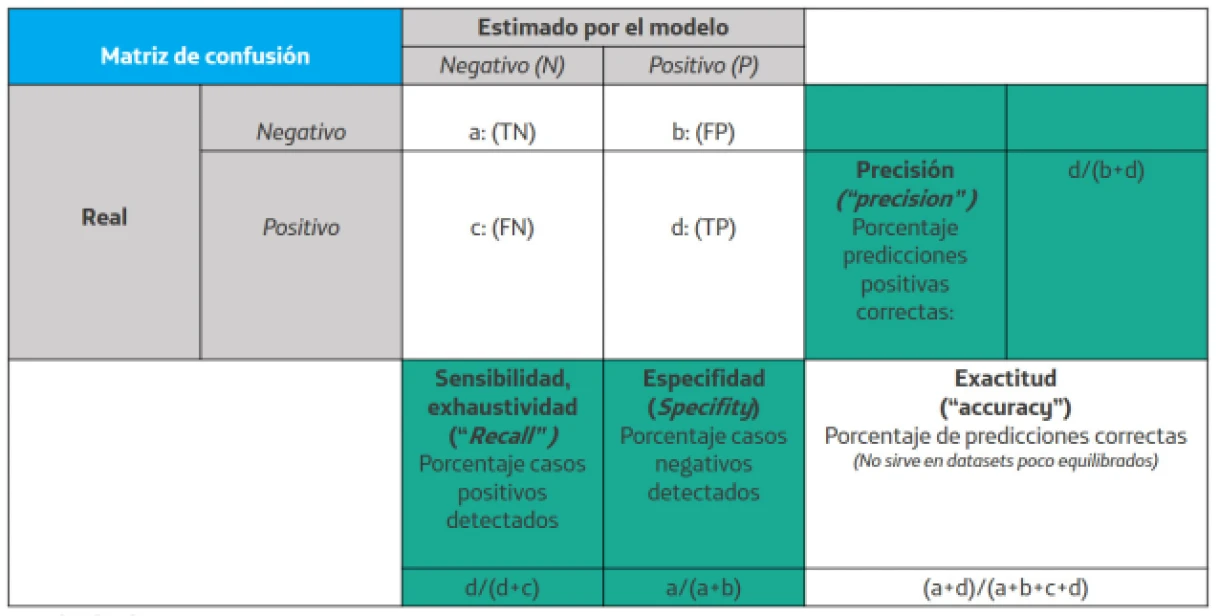

In [80]:
# tabla para los valores de la matriz de confusion - se le agrega el nombre de la columna segun el metodo
dfMConf = pd.DataFrame(index = ['TN', 'FP', 'FN','TP'])
# tabla para los valores de la matriz de confusion - se le agrega el nombre de la columna segun si solo SP o EEG
dfMConfCaract = pd.DataFrame(index = ['TN', 'FP', 'FN','TP'])

### Funciones para el aprendizaje automático: 


Se define la función valoresMC para calcular las métricas del modelo a partir de los valores de la matriz de confusión.

La métricas que nos interesa calcular son:
* Sensibilidad (recall): Es la proporción de casos positivos que fueron correctamente identificados por el algoritmo. También se conoce como Tasa de Verdaderos Positivos.
* Especificidad (true negative rate): Es la proporción de casos negativos que fueron correctamente identificados por el algoritmo. También se conoce como Tasa de Verdaderos Negativos.
* Precisión (precision): Es la proporción de casos positivos que fueron detectados correctamente por el algoritmo en relación a los casos positivos totales. También se conoce como Verdaderos Positivos.
* Exactitud (accuracy): Es la proporción de predicciones correctas, tanto positivas como negativas, en relación al total de predicciones realizadas por el algoritmo.

Dichas métricas se calculan de la siguiente manera:

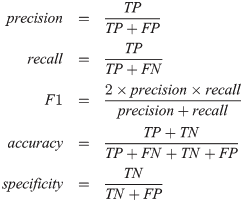 

In [81]:
def valoresMC(tn,fp,fn,tp): # tn = a ,fp = b,fn = c,tp =d
  vals = []
  sens = tp/(tp+fn) # d/d+c
  vals.append(['Sensibilidad:', sens])
  especif = tn/ (tn+fp) # a/a+b
  vals.append(['Especificidad:', especif])
  prec = tp/(fp+tp) # d/b+d
  vals.append(['Precision:', prec])
  exact = (tn+tp) / (tn+tp+fn+fp)# a+d/ a+b+d+c
  vals.append(['Exactitud:', exact])
  return vals

###### Curva ROC

Se define la función ROC para graficar la curva ROC a partir de los resultados del modelo de aprendizaje automático y para el cálculo del área bajo la curva (AUC).

La curva de Característica Operativa del Receptor (ROC) se obtiene al trazar la tasa de verdaderos positivos (sensibilidad) frente a la tasa de falsos positivos (1 - especificidad). Esta curva nos permite visualizar el equilibrio entre la tasa de verdaderos positivos y la tasa falsos positivos, informa sobre la capacidad del modelo de distinguir entre dos cosas. El área bajo la curva (AUC) brinda mayor información sobre el funcionamiento del modelo, lo ideal es que el valor se acerque a 1, ya que si es igual a 1 el modelo predice perfectamente, y si es 0.5 indica que el modelo no tiene capacidad de discriminación para distinguir entre la clase positiva y la negativa.


In [82]:
def ROC(X_test, y_test, model, grafico = False):
  # probabilidades de cada valor binario
  probs = model.predict_proba(X_test)
  # tomo las probabilidades para valor 1 (valor 0 es 1 - probs)
  probs = probs[:, 1]

  auc = roc_auc_score(y_test, probs)
  print('AUC - Test Set: %.2f%%' % (auc*100))

  # calculo de los parametros de roc
  fpr, tpr, thresholds = roc_curve(y_test, probs)
  if grafico:
    # grafico del 0.5
    plt.plot([0, 1], [0, 1], linestyle='--')
    # grafico de la curva roc
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False positive rate')
    plt.ylabel('Sensibilidad')
    plt.show()

  return auc, fpr, tpr, thresholds

### Modelos de aprendizaje automático:
Se utilizan diferentes modelos de aprendizaje automático para realizar la clasificación binaria de Arousal (calmado o exitado) y de Valencia (agradable o desagradable) representados como 0 o 1. Luego, se compara el rendimiento de cada uno de los siguientes para poder concluir cual es el mejor para cada caso.

1. Regresión Logística
  
  Es un tipo de Modelo Lineal Generalizado (generalización de la regresión lineal ordinaria) que utiliza una función logística para modelar la dependencia entre una variable binaria dependiente basada en cualquier tipo de variables independientes.
2. SVM 

  Las máquinas de vectores de apoyo (SVM) son un tipo de algoritmo de clasificación flexible, ya que pueden realizar una clasificación lineal, pero pueden utilizar otras funciones base no lineales. El algoritmo elige la frontera de decisión que maximiza la distancia de los puntos de datos más cercanos de todas las clases. Encuentra la frontera de decisión más óptima que es la que tiene el máximo margen desde los puntos más cercanos de todas las clases. Los puntos más cercanos a la frontera de decisión que maximizan la distancia entre la frontera de decisión y los puntos se denominan vectores de soporte. La frontera de decisión en el caso de las SVM se llama clasificador de margen máximo, o hiperplano de margen máximo.

3. Random Forest

  Es un tipo de algoritmo de aprendizaje automático supervisado basado en el aprendizaje por conjuntos. El aprendizaje por conjuntos es un tipo de aprendizaje en el que se unen diferentes tipos de algoritmos o el mismo algoritmo varias veces para formar un modelo de predicción más potente. El algoritmo de Random Forest combina múltiples algoritmos del mismo tipo, es decir, múltiples árboles de decisión, lo que da lugar a un bosque de árboles, de ahí el nombre de "Random Forest" o "bosque aleatorio". Los pasos básicos que se siguen para realizar el algoritmo son: elegir N registros al azar del conjunto de datos, construir un árbol de decisión basado en estos N registros, elegir el número de árboles a realizar y repetir los primeros dos pasos. En el caso de un problema de clasificación, cada árbol predice la categoría a la que pertenece el nuevo registro. Finalmente, el nuevo registro se asigna a la categoría que gana la mayoría de los votos.





### Selector de K características para cada clase


Dada la gran cantidad de características que se obtuvieron se procede a seleccionar, mediante el algoritmo de SelectKBest, un conjunto de estas que optimice el resultado de método de aprendizaje automático. Se probaron distintas cantidades, k, de características para tener en cuenta y observando las métricas de los modelos se llegó a la conclusión de que seleccionando 25 se obtenian los mejores resultados.

Dicha selección se lleva a cabo a continuación:

In [83]:
X = matrizTotal.copy().drop(['Valence P', 'Arousal P', 'Valence 5', 'Arousal 5'], axis =1)
y = matrizTotal.copy().loc[:,['Valence P', 'Arousal P', 'Valence 5', 'Arousal 5']]
columnas_i = []
for i in range(4):
  selector = SelectKBest(k=25).fit(X, y.iloc[:,i])
  cols = selector.get_support(indices=True)
  columnas = X.columns[cols]
  clase = y.columns[i]
  columnas_i.append([clase,columnas])

columnas_i

[['Valence P',
  Index(['Freq Dom Alpha 0', 'Freq Dom Gamma 0', 'Freq Dom Alpha 1',
         'Freq Dom Beta 1', 'Freq Dom Alpha 2', 'Freq Dom Gamma 2',
         'Freq Dom Gamma 3', 'Freq Dom Tot 4', 'Freq Dom Tot 5',
         'Freq Dom Gamma 5', 'Freq Dom Tot 6', 'Freq Dom Beta 6',
         'Freq Dom Tot 7', 'Freq Dom Beta 7', 'Pw Media Tot 1',
         'Pw Media Alpha 1', 'Pw Media Beta 1', 'Pw Media Gamma 1',
         'Pw Media Tot 5', 'Pw Media Alpha 5', 'Pw Media Gamma 5',
         'GSR promedio', 'GSR derivada', 'Frec Dom TMP', 'Frec Dom PPG'],
        dtype='object')],
 ['Arousal P',
  Index(['Freq Dom Alpha 0', 'Freq Dom Beta 0', 'Freq Dom Alpha 1',
         'Freq Dom Beta 1', 'Freq Dom Beta 2', 'Freq Dom Gamma 2',
         'Freq Dom Alpha 3', 'Freq Dom Beta 3', 'Freq Dom Alpha 4',
         'Freq Dom Beta 4', 'Freq Dom Gamma 4', 'Freq Dom Alpha 5',
         'Freq Dom Beta 5', 'Freq Dom Alpha 6', 'Freq Dom Beta 6',
         'Freq Dom Beta 7', 'Freq Dom Gamma 7', 'Pw Media Gamma 4

### Modelos utilizados con matriz completa.
Se implementan los modelos establecidos utilizando las 25 características obtenidas en su totalidad.

#### Valencia P
Se generan los sets de datos de entrenamiento y de prueba para la predicción de Valencia binarizada mediante la media.

In [84]:
colsVP = columnas_i[0][1]
varVP =  columnas_i[0][0]
X_trainVP = trainX.loc[:,colsVP]
y_trainVP = trainY.loc[:,varVP]
X_testVP = testX.loc[:,colsVP]
y_testVP = testY.loc[:,varVP]

##### Regresión logística


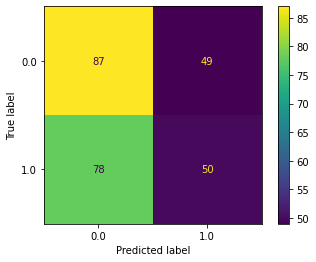

AUC - Test Set: 55.40%


In [85]:
LR1 = LogisticRegression(max_iter = 1000)
LR1.fit(X_trainVP, y_trainVP)
prediccionesLR1 = LR1.predict(X_testVP)

tnLR1, fpLR1, fnLR1, tpLR1 = sklearn.metrics.confusion_matrix(y_testVP, prediccionesLR1).ravel()
dfMConf.loc[['TN', 'FP', 'FN','TP'], 'Valence P - RegLog'] = [tnLR1, fpLR1, fnLR1, tpLR1]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_testVP, prediccionesLR1)
plt.show()

aucLR1, fprLR1, tprLR1, thresholdsLR1 = ROC(X_test =X_testVP , y_test= y_testVP, model = LR1,grafico= False)


##### SVM


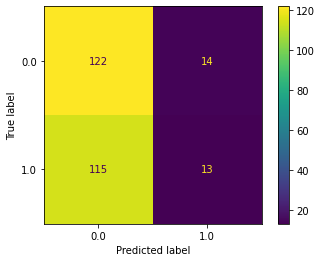

AUC - Test Set: 51.76%


In [86]:
SVM1 = svm.SVC(probability = True)
SVM1.fit(X_trainVP, y_trainVP)
prediccionesSVM1 = SVM1.predict(X_testVP)

tnSVM1, fpSVM1, fnSVM1, tpSVM1 = sklearn.metrics.confusion_matrix(y_testVP, prediccionesSVM1).ravel()
dfMConf.loc[['TN', 'FP', 'FN','TP'], 'Valence P - SVM'] = [tnSVM1, fpSVM1, fnSVM1, tpSVM1]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_testVP,prediccionesSVM1)
plt.show()

aucLR1, fprLR1, tprLR1, thresholdsLR1 = ROC(X_test =X_testVP , y_test= y_testVP, model = SVM1,grafico= False)

##### Random Forest

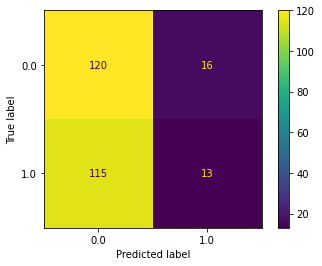

AUC - Test Set: 57.00%


In [87]:
RF1 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RF1.fit(X_trainVP, y_trainVP)
prediccionRF1 = RF1.predict(X_testVP)

tnRF1, fpRF1, fnRF1, tpRF1 = sklearn.metrics.confusion_matrix(y_testVP,prediccionRF1).ravel()
dfMConf.loc[['TN', 'FP', 'FN','TP'], 'Valence P - RandForest'] = [tnRF1, fpRF1, fnRF1, tpRF1]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_testVP, prediccionRF1)
plt.show()

aucRF1, fprRF1, tprRF1, thresholdsRF1 = ROC(X_test =X_testVP , y_test= y_testVP, model = RF1, grafico= False)

#### Valencia 5
Se generan los sets de datos de entrenamiento y de prueba para la predicción de Valencia binarizada mediante el valor central.

In [88]:
colsV5 = columnas_i[2][1]
varV5 =  columnas_i[2][0]
X_trainV5 = trainX.loc[:,colsV5]
y_trainV5 = trainY.loc[:,varV5]
X_testV5 = testX.loc[:,colsV5]
y_testV5 = testY.loc[:,varV5]

##### Regresión Logística

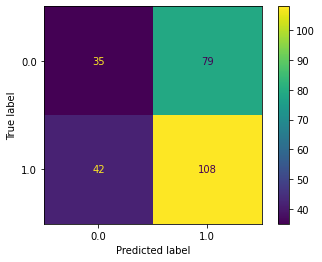

AUC - Test Set: 54.79%


In [89]:
LR2 = LogisticRegression(max_iter = 10000).fit(X_trainV5, y_trainV5)
prediccionesLR2 = LR2.predict(X_testV5)

tnLR2, fpLR2, fnLR2, tpLR2 = sklearn.metrics.confusion_matrix(y_testV5,prediccionesLR2).ravel()
dfMConf.loc[['TN', 'FP', 'FN','TP'], 'Valence 5 - RegLog'] = [tnLR2, fpLR2, fnLR2, tpLR2]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_testV5, prediccionesLR2)
plt.show()

aucLR2, fprLR2, tprLR2, thresholdsLR2 = ROC(X_test =X_testV5 , y_test=y_testV5, model = LR2,grafico= False)

##### SVM

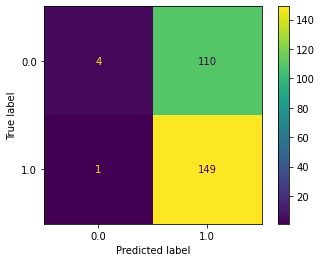

AUC - Test Set: 41.12%


In [90]:
SVM2 = svm.SVC(probability=True)
SVM2.fit(X_trainV5, y_trainV5)
prediccionesSVM2 = SVM2.predict(X_testV5)

tnSVM2, fpSVM2, fnSVM2, tpSVM2 = sklearn.metrics.confusion_matrix(y_testV5, prediccionesSVM2).ravel()
dfMConf.loc[['TN', 'FP', 'FN','TP'], 'Valence 5 - SVM'] = [tnSVM2, fpSVM2, fnSVM2, tpSVM2]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_testV5, prediccionesSVM2)
plt.show()

aucSVM2, fprSVM2, tprSVM2, thresholdsSVM2 = ROC(X_test =X_testV5 , y_test=y_testV5, model = SVM2,grafico= False)

##### Random Forest

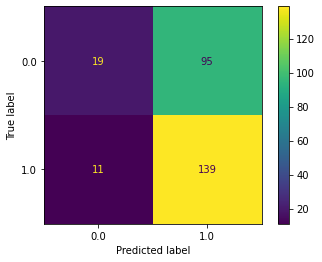

AUC - Test Set: 57.46%


In [91]:
RF2 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RF2.fit(X_trainV5, y_trainV5 )
prediccionRF2 = RF2.predict(X_testV5)

tnRF2, fpRF2, fnRF2, tpRF2 = sklearn.metrics.confusion_matrix( y_testV5, prediccionRF2).ravel()
dfMConf.loc[['TN', 'FP', 'FN','TP'], 'Valence 5 - RandForest'] = [tnRF2, fpRF2, fnRF2, tpRF2]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_testV5 , prediccionRF2)
plt.show()

aucRF2, fprRF2, tprRF2, thresholdsRF2 = ROC(X_test =X_testV5 , y_test=y_testV5, model = RF2,grafico= False)

#### Scores para Valencia
Se visualizan todas las métricas arrojadas por los modelos aplicados para la clasificación de Valencia.

In [92]:
dffScore_valencia = pd.DataFrame(columns=dfMConf.columns)
for col in dfMConf.columns: 
  tn,fp,fn,tp = dfMConf.loc[['TN', 'FP', 'FN','TP'], col] 
  lista = valoresMC(tn,fp,fn,tp)
  for i in range(len(lista)):
    score = lista[i][0]
    dffScore_valencia.loc[score,col] = lista[i][1]
dffScore_valencia

Valence P - RegLog  ... Valence 5 - RandForest
Sensibilidad:            0.390625  ...               0.926667
Especificidad:           0.639706  ...               0.166667
Precision:               0.505051  ...               0.594017
Exactitud:               0.518939  ...               0.598485

[4 rows x 6 columns]

In [93]:
for j in range(len(dffScore_valencia)):
  fila = dffScore_valencia.index[j]
  col_i = np.where(dffScore_valencia.iloc[j,0:3]==np.max(dffScore_valencia.iloc[j,0:3]))[0]
  col = dffScore_valencia.columns[col_i][0]

  print('Max de', fila, 'esta en ', str(col))
print()
for j in range(len(dffScore_valencia)):
  end = len(dffScore_valencia.columns)
  fila = dffScore_valencia.index[j]
  col_i = np.where(dffScore_valencia.iloc[j,3:end]==np.max(dffScore_valencia.iloc[j,3:end]))[0]
  col = dffScore_valencia.columns[col_i+3][0]
  print('Max de', fila, 'esta en ', str(col))

Max de Sensibilidad: esta en  Valence P - RegLog
Max de Especificidad: esta en  Valence P - SVM
Max de Precision: esta en  Valence P - RegLog
Max de Exactitud: esta en  Valence P - RegLog

Max de Sensibilidad: esta en  Valence 5 - SVM
Max de Especificidad: esta en  Valence 5 - RegLog
Max de Precision: esta en  Valence 5 - RandForest
Max de Exactitud: esta en  Valence 5 - RandForest


In [94]:
for fila in dffScore_valencia.index:
  col_i = np.where(dffScore_valencia.loc[fila]==np.max(dffScore_valencia.loc[fila]))[0]
  col = dffScore_valencia.columns[col_i][0]
  print('Max de', fila, 'esta en ', str(col))

Max de Sensibilidad: esta en  Valence 5 - SVM
Max de Especificidad: esta en  Valence P - SVM
Max de Precision: esta en  Valence 5 - RandForest
Max de Exactitud: esta en  Valence 5 - RandForest


En vista de los resultados se concluye que la Valencia binarizada mediante el valor central de la escala, es decir el valor 5, es la forma en la que mejor se puede predecir dicho estado emocional. El modelo que arroja las mejores métricas, considerando que no tiene mayor peso un falso positivo que un falso negativo si no que se busca obtener un modelo que prediga ambas situaciones de la mejor manera, es el de Random Forest. Se llega a esa conclusión, en primer lugar, porque la exactitud (métrica que establece con qué frecuencia es correcto el clasificador) es la mayor y, luego, observando y comparando las demás métricas se tiene que son buenas también, con la exepción de la especificidad pero aún así es mayor que la sensibilidad en los modelos que tienen mejores resultados de especifidad.

#### Valencia con características según el tipo de muestra
A continuación se utilizan las características obtenidas de las señales periféricas y EEG por separado para predecir la Valencia y observar de que manera se obtienen mejores resultados. Se aplica el modelo de Random Forest para predecir Valencia 5 y el de Regresión Logística para Valencia P, ya que dichos modelos fueron los que arrojaron mejores resultados para la clasificación en cada caso.


##### Valencia para EEG

In [95]:
colsEEGV5 = colsV5[0:20]
colsEEGVP = colsVP[0:21]

trainX_EEG = trainX.copy()
testX_EEG = testX.copy()

trainX_EEGVP = trainX_EEG.loc[:,colsEEGVP]
testX_EEGVP = testX_EEG.loc[:,colsEEGVP]

trainX_EEGV5 = trainX_EEG.loc[:,colsEEGV5]
testX_EEGV5 = testX_EEG.loc[:,colsEEGV5]

Valence P


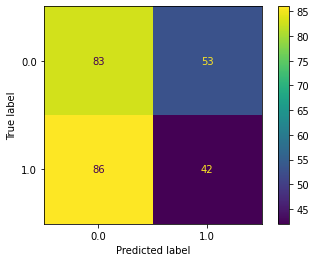

AUC - Test Set: 48.50%


In [96]:
# Regresion Logística Para Valencia P
print(varVP)
RFEEG1 = LogisticRegression(max_iter = 10000).fit(trainX_EEGVP, trainY[varVP])
prediccionRFEEG1 = RFEEG1.predict(testX_EEGVP)

tnRFEEG1, fpRFEEG1, fnRFEEG1, tpRFEEG1 = sklearn.metrics.confusion_matrix(testY[varVP], prediccionRFEEG1).ravel()
dfMConfCaract.loc[['TN', 'FP', 'FN','TP'], 'Valence P - EEG'] = [tnRFEEG1, fpRFEEG1, fnRFEEG1, tpRFEEG1]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(testY[varVP], prediccionRFEEG1)
plt.show()

aucRF2, fprRF2, tprRF2, thresholdsRF2 = ROC(X_test =testX_EEGVP , y_test=testY[varVP], model = RFEEG1, grafico= False)

Valence 5


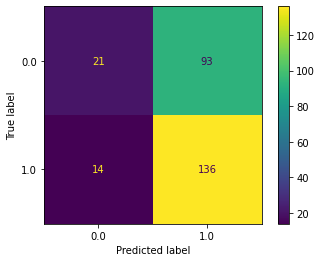

AUC - Test Set: 54.12%


In [97]:
# Random Forest para Valencia 5
print(varV5)
RFEEG2 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RFEEG2.fit(trainX_EEGV5, trainY[varV5])
prediccionRFEEG2 = RFEEG2.predict(testX_EEGV5)

tnRFEEG2, fpRFEEG2, fnRFEEG2, tpRFEEG2 = sklearn.metrics.confusion_matrix(testY[varV5], prediccionRFEEG2).ravel()
dfMConfCaract.loc[['TN', 'FP', 'FN','TP'], 'Valence 5 - EEG'] = [tnRFEEG2, fpRFEEG2, fnRFEEG2, tpRFEEG2]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(testY[varV5], prediccionRFEEG2)
plt.show()


aucRF2, fprRF2, tprRF2, thresholdsRF2 = ROC(X_test =testX_EEGV5, y_test=testY[varVP], model = RFEEG2, grafico= False)

También se realiza con todas las características obtenidas de las señales de EEG con el fin de comparar resultados.

In [98]:
trainEEG = trainX[matrizEEG.drop(['Participante','Trial'],axis=1).columns]
testEEG = testX[matrizEEG.drop(['Participante','Trial'],axis=1).columns]

Valence P


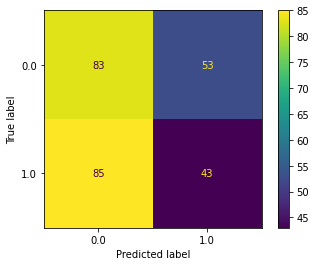

AUC - Test Set: 45.74%


In [99]:
# Regresión Logística Para Valencia P
print(varVP)
LREEG1tot = LogisticRegression(max_iter = 10000).fit(trainEEG, trainY[varVP])
prediccionLREEG1tot = LREEG1tot.predict(testEEG)

tnLREEG1tot, fpLREEG1tot, fnLREEG1tot, tpLREEG1tot = sklearn.metrics.confusion_matrix(testY[varVP], prediccionLREEG1tot).ravel()
dfMConfCaract.loc[['TN', 'FP', 'FN','TP'], 'Valence P - EEG tot'] = [tnLREEG1tot, fpLREEG1tot, fnLREEG1tot, tpLREEG1tot]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(testY[varVP], prediccionLREEG1tot)
plt.show()

aucLREEG1tot, fprLREEG1tot, tprLREEG1tot, thresholdsLREEG1tot = ROC(X_test =testEEG , y_test=testY[varVP], model = LREEG1tot, grafico= False)

Valence 5


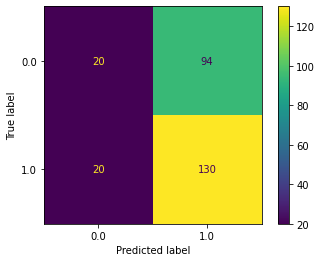

AUC - Test Set: 47.79%


In [100]:
# Random Forest para Valencia 5
print(varV5)
RFEEG2tot = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0).fit(trainEEG, trainY[varV5])
prediccionRFEEG2tot = RFEEG2tot.predict(testEEG)

tnRFEEG2tot, fpRFEEG2tot, fnRFEEG2tot, tpRFEEG2tot = sklearn.metrics.confusion_matrix(testY[varV5], prediccionRFEEG2tot).ravel()
dfMConfCaract.loc[['TN', 'FP', 'FN','TP'], 'Valence 5 - EEG tot'] = [tnRFEEG2tot, fpRFEEG2tot, fnRFEEG2tot, tpRFEEG2tot ]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(testY[varV5], prediccionRFEEG2tot)
plt.show()


aucRF2tot, fprRF2tot, tprRF2tot, thresholdsRF2tot = ROC(X_test =testEEG, y_test=testY[varVP], model = RFEEG2tot, grafico= False)

##### Valencia para Señales Periféricas

In [101]:
trainX_SPV5 = X_trainV5.drop(colsEEGV5,axis = 1)
testX_SPV5 = X_testV5.copy().drop(colsEEGV5, axis=1)

trainX_SPVP = X_trainVP.drop(colsEEGVP,axis = 1)
testX_SPVP = X_testVP.copy().drop(colsEEGVP, axis=1)

Valence P


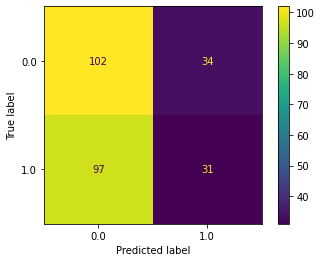

AUC - Test Set: 54.45%


In [102]:
# Regresión Logística Para Valencia P
print(varVP)
LRSP1 = LogisticRegression(max_iter = 10000).fit(trainX_SPVP, trainY[varVP])
prediccionLRSP1 = LRSP1.predict(testX_SPVP)

tnLRSP1, fpLRSP1, fnLRSP1, tpLRSP1 = sklearn.metrics.confusion_matrix(testY[varVP], prediccionLRSP1).ravel()
dfMConfCaract.loc[['TN', 'FP', 'FN','TP'], 'Valence P - SP'] = [tnLRSP1, fpLRSP1, fnLRSP1, tpLRSP1]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(testY[varVP], prediccionLRSP1)
plt.show()

aucLRSP1, fprLRSP1, tprLRSP1, thresholdsLRSP1 = ROC(X_test =testX_SPVP, y_test=testY[varVP], model = LRSP1, grafico= False)

Valence 5


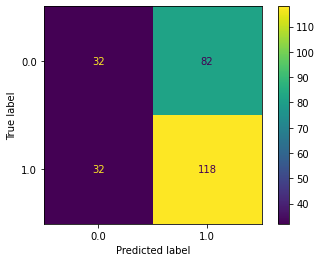

AUC - Test Set: 56.03%


In [103]:
# Random Forest para Valencia 5
print(varV5)
RFSP2 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RFSP2.fit(trainX_SPV5, trainY[varV5])
prediccionRFSP2 = RFSP2.predict(testX_SPV5)

tnRFSP2, fpRFSP2, fnRFSP2, tpRFSP2 = sklearn.metrics.confusion_matrix(testY[varV5], prediccionRFSP2).ravel()
dfMConfCaract.loc[['TN', 'FP', 'FN','TP'], 'Valence 5 - SP'] = [tnRFSP2, fpRFSP2, fnRFSP2, tpRFSP2]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(testY[varV5],prediccionRFSP2)
plt.show()

aucRFSP2, fprRFSP2, tprRFSP2, thresholdsRFSP2 = ROC(X_test =testX_SPV5, y_test=testY[varV5], model = RFSP2, grafico= False)

También se realiza con todas las características obtenidas de las señales periféricas.

In [104]:
trainSP = trainX.drop(matrizEEG.drop(['Participante','Trial'],axis=1).columns,axis=1)
testSP = testX.drop(matrizEEG.drop(['Participante','Trial'],axis=1).columns,axis=1)

Valence P


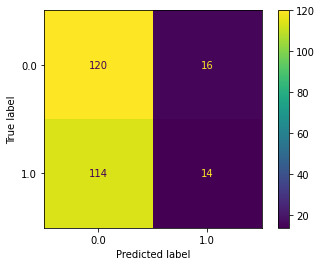

AUC - Test Set: 54.14%


In [105]:
# Regresión Logística Para Valencia P
print(varVP)
LRSP1tot = LogisticRegression(max_iter = 10000).fit(trainSP, trainY[varVP])
prediccionLRSP1tot = LRSP1tot.predict(testSP)

tnLRSP1tot, fpLRSP1tot, fnLRSP1tot, tpLRSP1tot = sklearn.metrics.confusion_matrix(testY[varVP], prediccionLRSP1tot).ravel()
dfMConfCaract.loc[['TN', 'FP', 'FN','TP'], 'Valence P - SP tot'] = [tnLRSP1tot, fpLRSP1tot, fnLRSP1tot, tpLRSP1tot]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(testY[varVP], prediccionLRSP1tot)
plt.show()

aucLRSP1tot, fprLRSP1tot, tprLRSP1tot, thresholdsLRSP1tot = ROC(X_test =testSP, y_test=testY[varVP], model = LRSP1tot, grafico= False)

Valence 5


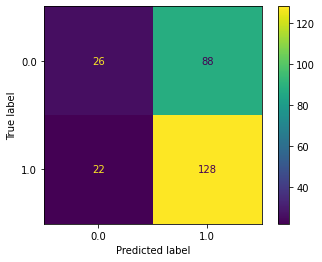

AUC - Test Set: 53.73%


In [106]:
# Random Forest para Valencia 5
print(varV5)
RFSP2tot = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0).fit(trainSP, trainY[varV5])
prediccionRFSP2tot = RFSP2tot.predict(testSP)

tnRFSP2tot, fpRFSP2tot, fnRFSP2tot, tpRFSP2tot = sklearn.metrics.confusion_matrix(testY[varV5], prediccionRFSP2tot).ravel()
dfMConfCaract.loc[['TN', 'FP', 'FN','TP'], 'Valence 5 - SP tot'] = [tnRFSP2tot, fpRFSP2tot, fnRFSP2tot, tpRFSP2tot]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(testY[varV5],prediccionRFSP2tot)
plt.show()

aucRFSP2tot, fprRFSP2tot, tprRFSP2tot, thresholdsRFSP2tot = ROC(X_test =testSP, y_test=testY[varV5], model = RFSP2tot, grafico= False)


#### Arousal P

Se generan los sets de datos de entrenamiento y de prueba para la predicción de Arousal binarizada mediante la media.

In [107]:
colsAP = columnas_i[1][1]
varAP =  columnas_i[1][0]
X_trainAP = trainX[colsAP]
y_trainAP = trainY[varAP]
X_testAP = testX[colsAP]
y_testAP = testY[varAP]

##### Regresión Logística


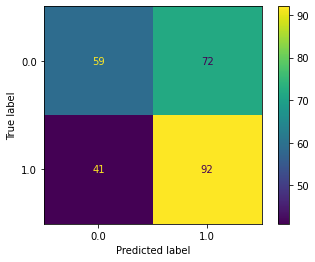

AUC - Test Set: 62.39%


In [108]:
LR3 = LogisticRegression(max_iter = 10000).fit(X_trainAP, y_trainAP)
prediccionesLR3 = LR3.predict(X_testAP)

tnLR3, fpLR3, fnLR3, tpLR3 = sklearn.metrics.confusion_matrix(y_testAP, prediccionesLR3).ravel()
dfMConf.loc[['TN', 'FP', 'FN','TP'], 'Arousal P - RegLog'] = [tnLR3, fpLR3, fnLR3, tpLR3]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_testAP, prediccionesLR3)
plt.show()

aucLR3, fprLR3, tprLR3, thresholdsLR3 = ROC(X_test =X_testAP , y_test= y_testAP, model = LR3,grafico= False)

##### SVM


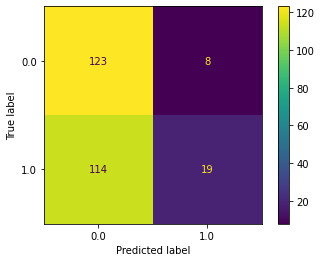

AUC - Test Set: 52.55%


In [109]:
SVM3 = svm.SVC(probability=True).fit(X_trainAP,y_trainAP)
prediccionesSVM3 = SVM3.predict(X_testAP)

tnSVM3, fpSVM3, fnSVM3, tpSVM3 = sklearn.metrics.confusion_matrix(y_testAP,prediccionesSVM3).ravel()
dfMConf.loc[['TN', 'FP', 'FN','TP'], 'Arousal P - SVM'] = [tnSVM3, fpSVM3, fnSVM3, tpSVM3]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_testAP, prediccionesSVM1)
plt.show()

aucSVM3, fprSVM3, tprSVM3, thresholdsSVM3 = ROC(X_test =X_testAP , y_test=y_testAP, model = SVM3,grafico= False)

##### Random Forest

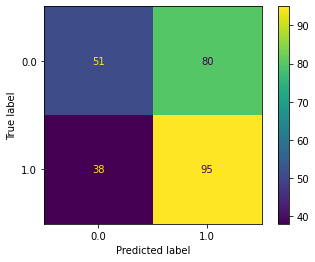

AUC - Test Set: 58.46%


In [110]:
RF3 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RF3.fit(X_trainAP, y_trainAP)
prediccionRF3 = RF3.predict(X_testAP)

tnRF3, fpRF3, fnRF3, tpRF3 = sklearn.metrics.confusion_matrix( y_testAP, prediccionRF3).ravel()
dfMConf.loc[['TN', 'FP', 'FN','TP'], 'Arousal P - RandForest'] = [tnRF3, fpRF3, fnRF3, tpRF3]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_testAP , prediccionRF3)
plt.show()


aucRF3, fprRF3, tprRF3, thresholdsRF3 = ROC(X_test =X_testAP , y_test=y_testAP, model = RF3,grafico= False)

#### Arousal 5

Se generan los sets de datos de entrenamiento y de prueba para la predicción de Arousal binarizada mediante el valor central.

In [111]:
colsA5 = columnas_i[3][1]
varA5 =  columnas_i[3][0]
X_trainA5 = trainX.loc[:,colsA5]
y_trainA5 = trainY.loc[:,varA5]
X_testA5 = testX.loc[:,colsA5]
y_testA5 = testY.loc[:,varA5]

##### Regresión Logística


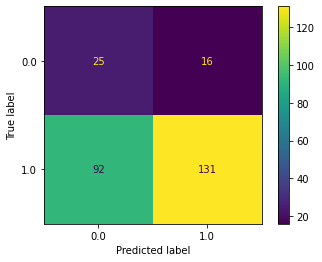

AUC - Test Set: 63.80%


In [112]:
LR4 = LogisticRegression(max_iter = 500).fit(X_trainA5, y_trainA5)
prediccionesLR4 = LR4.predict(X_testA5)

tnLR4, fpLR4, fnLR4, tpLR4 = sklearn.metrics.confusion_matrix(y_testA5,prediccionesLR4).ravel()
dfMConf.loc[['TN', 'FP', 'FN','TP'], 'Arousal 5 - RegLog'] = [tnLR4, fpLR4, fnLR4, tpLR4]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(prediccionesLR4,y_testA5)
plt.show()
# curva ROC
aucLR4, fprLR4, tprLR4, thresholdsLR4 = ROC(X_test =X_testA5 , y_test= y_testA5, model = LR4,grafico= False)

##### SVM


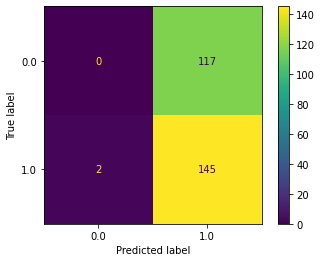

AUC - Test Set: 46.01%


In [113]:
SVM4 = svm.SVC(probability=True).fit(X_trainA5, y_trainA5)
prediccionesSVM4 = SVM4.predict(X_testA5)
# tomo los valores de la matriz confusion para poder analizar todo junto despues
tnSVM4, fpSVM4, fnSVM4, tpSVM4 = sklearn.metrics.confusion_matrix(y_testA5,prediccionesSVM4).ravel()
# se ponen los valores en el df de matriz de confusion 
dfMConf.loc[['TN', 'FP', 'FN','TP'], 'Arousal 5 - SVM'] = [tnSVM4, fpSVM4, fnSVM4, tpSVM4]
# se grafica la matriz de confusion
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_testA5, prediccionesSVM4)
plt.show()

aucSVM4, fprSVM4, tprSVM4, thresholdsSVM4 = ROC(X_test =X_testA5 , y_test= y_testA5, model = SVM4,grafico= False)

##### Random Forest

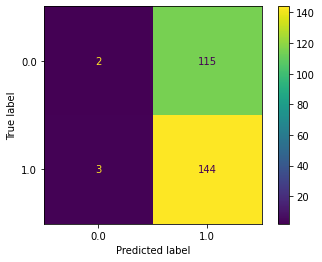

AUC - Test Set: 59.81%


In [114]:
RF4 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RF4.fit(X_trainA5, y_trainA5)
prediccionRF4 = RF4.predict(X_testA5)

tnRF4, fpRF4, fnRF4, tpRF4 = sklearn.metrics.confusion_matrix(y_testA5,prediccionRF4).ravel()
dfMConf.loc[['TN', 'FP', 'FN','TP'], 'Arousal 5 - RandForest'] = [tnRF4, fpRF4, fnRF4, tpRF4]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_testA5, prediccionRF4)
plt.show()

aucRF4, fprRF4, tprRF4, thresholdsRF4 = ROC(X_test =X_testA5 , y_test= y_testA5, model = RF4,grafico= False)

#### Scores para Arousal
Se visualizan todas las métricas arrojadas por los modelos aplicados para la clasificación de Arousal, utilizando las 25 características.

In [115]:
dfMConf

Valence P - RegLog  ...  Arousal 5 - RandForest
TN                87.0  ...                     2.0
FP                49.0  ...                   115.0
FN                78.0  ...                     3.0
TP                50.0  ...                   144.0

[4 rows x 12 columns]

In [116]:
columnasA = dfMConf.columns.drop(dffScore_valencia.columns)
dffScore_Arousal = pd.DataFrame(columns=columnasA)
for col in dffScore_Arousal.columns: 
  tn,fp,fn,tp = dfMConf.loc[['TN', 'FP', 'FN','TP'], col] 
  lista = valoresMC(tn,fp,fn,tp)
  for i in range(len(lista)):
    score = lista[i][0]
    dffScore_Arousal.loc[score,col] = lista[i][1]
dffScore_Arousal

Arousal P - RegLog  ... Arousal 5 - RandForest
Sensibilidad:            0.691729  ...               0.979592
Especificidad:           0.450382  ...               0.017094
Precision:               0.560976  ...               0.555985
Exactitud:                0.57197  ...                0.55303

[4 rows x 6 columns]

In [117]:
for j in range(len(dffScore_Arousal)):
  fila = dffScore_Arousal.index[j]
  col_i = np.where(dffScore_Arousal.iloc[j,0:3]==np.max(dffScore_Arousal.iloc[j,0:3]))[0]
  col = dffScore_Arousal.columns[col_i][0]
  print('Max de', fila, 'esta en ', str(col))

print()
for j in range(len(dffScore_Arousal)):
  end = len(dffScore_Arousal.columns)
  fila = dffScore_Arousal.index[j]
  col_i = np.where(dffScore_Arousal.iloc[j,3:end]==np.max(dffScore_Arousal.iloc[j,3:end]))[0]
  col = dffScore_Arousal.columns[col_i+3][0]
  print('Max de', fila, 'esta en ', str(col))

Max de Sensibilidad: esta en  Arousal P - SVM
Max de Especificidad: esta en  Arousal P - RegLog
Max de Precision: esta en  Arousal P - RegLog
Max de Exactitud: esta en  Arousal P - RegLog

Max de Sensibilidad: esta en  Arousal 5 - SVM
Max de Especificidad: esta en  Arousal 5 - RegLog
Max de Precision: esta en  Arousal 5 - RegLog
Max de Exactitud: esta en  Arousal 5 - RegLog


In [118]:
for fila in dffScore_Arousal.index:
  col_i = np.where(dffScore_Arousal.loc[fila]==np.max(dffScore_Arousal.loc[fila]))[0]
  col = dffScore_Arousal.columns[col_i][0]
  print('Max de', fila, 'esta en ', str(col))

Max de Sensibilidad: esta en  Arousal 5 - SVM
Max de Especificidad: esta en  Arousal P - RegLog
Max de Precision: esta en  Arousal 5 - RegLog
Max de Exactitud: esta en  Arousal 5 - RegLog


Observando los resultados se concluye que Arousal binarizada mediante el valor central de la escala, es decir el valor 5, es la forma en la que mejor se puede predecir dicho estado emocional. El modelo que arroja las mejores métricas es el de Regresión Logística. Se llega a esa conclusión, en primer lugar, porque la exactitud, precisión y especificidad que se calculan son las máximas y, luego, observando la especificidad se tiene un valor bajo pero analizando y comparando los demás resultados se considera aceptable.

#### Arousal con características según tipo de muestra

A continuación se utilizan las características obtenidas de las señales periféricas y EEG por separado para predecir Arousal y observar de que manera se obtienen mejores resultados. Se aplica el modelo de Regresión Logística para predecir Arousal 5 y Arousal P, ya que fue el que arrojó mejores resultados para la clasificación en cada caso.

##### Arousal con EEG

In [119]:
# preparado de datos
colsEEGA5 = colsA5[0:19]
colsEEGAP = colsAP[0:18]

trainX_EEG = trainX.copy()
testX_EEG = testX.copy()

trainX_EEGAP = trainX_EEG.loc[:,colsEEGA5]
testX_EEGAP = testX_EEG.loc[:,colsEEGA5]

trainX_EEGA5 = trainX_EEG.loc[:,colsEEGA5]
testX_EEGA5 = testX_EEG.loc[:,colsEEGA5]

Arousal P


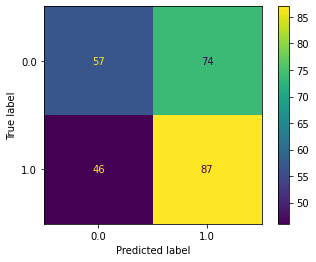

AUC - Test Set: 60.34%


In [120]:
# Regresión Logística para Arousal P
print(varAP)
LREEG1 = LogisticRegression(max_iter = 1000).fit(trainX_EEGAP, trainY[varAP])
prediccionesLREEG1 = LREEG1.predict(testX_EEGAP)

tnLREEG1, fpLREEG1, fnLREEG1, tpLREEG1 = sklearn.metrics.confusion_matrix(testY[varAP],prediccionesLREEG1).ravel()
dfMConfCaract.loc[['TN', 'FP', 'FN','TP'], 'Arousal P - EEG'] = [tnLREEG1, fpLREEG1, fnLREEG1, tpLREEG1]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(testY[varAP],prediccionesLREEG1)
plt.show()
# curva ROC
aucLREEG1, fprLREEG1, tprLREEG1, thresholdsLREEG1 = ROC(X_test =testX_EEGAP , y_test= testY[varAP], model = LREEG1,grafico= False)

Arousal 5


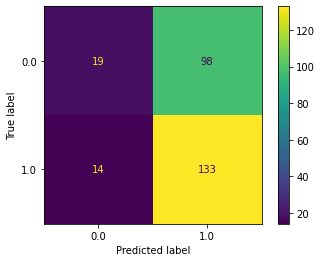

AUC - Test Set: 61.89%


In [121]:
# Regresión Logística para Arousal 5
print(varA5)
LREEG2 = LogisticRegression(max_iter = 1000).fit(trainX_EEGA5, trainY[varA5])
prediccionesLREEG2 = LREEG2.predict(testX_EEGA5)

tnLREEG2, fpLREEG2, fnLREEG2, tpLREEG2 = sklearn.metrics.confusion_matrix(testY[varA5],prediccionesLREEG2).ravel()
dfMConfCaract.loc[['TN', 'FP', 'FN','TP'], 'Arousal 5 - EEG'] = [tnLREEG2, fpLREEG2, fnLREEG2, tpLREEG2]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(testY[varA5],prediccionesLREEG2)
plt.show()
# curva ROC
aucLREEG2, fprLREEG2, tprLREEG2, thresholdsLREEG2 = ROC(X_test =testX_EEGA5 , y_test= testY[varA5], model = LREEG2,grafico= False)

También se realiza con todas las características obtenidas de las señales de EEG con el fin de comparar resultados.

In [122]:
trainEEG = trainX[matrizEEG.drop(['Participante','Trial'],axis=1).columns]
testEEG = testX[matrizEEG.drop(['Participante','Trial'],axis=1).columns]

Arousal P


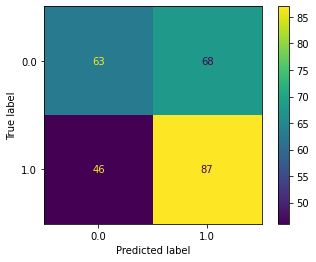

AUC - Test Set: 59.34%


In [123]:
print(varAP)
LREEG1tot = LogisticRegression(max_iter = 10000).fit(trainEEG, trainY[varAP])
prediccionesLREEG1tot = LREEG1tot.predict(testEEG)

tnLREEG1tot, fpLREEG1tot, fnLREEG1tot, tpLREEG1tot = sklearn.metrics.confusion_matrix(testY[varAP],prediccionesLREEG1tot).ravel()
dfMConfCaract.loc[['TN', 'FP', 'FN','TP'], 'Arousal P - EEG tot'] = [tnLREEG1tot, fpLREEG1tot, fnLREEG1tot, tpLREEG1tot]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(testY[varAP],prediccionesLREEG1tot)
plt.show()
# curva ROC
aucLREEG1tot, fprLREEG1tot, tprLREEG1tot, thresholdsLREEG1tot = ROC(X_test =testEEG , y_test= testY[varAP], model = LREEG1tot,grafico= False)

Arousal 5


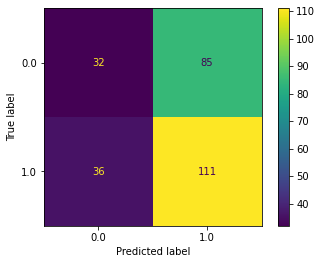

AUC - Test Set: 57.98%


In [124]:
print(varA5)
LREEG2tot = LogisticRegression(max_iter = 10000).fit(trainEEG, trainY[varA5])
prediccionesLREEG2tot = LREEG2tot.predict(testEEG)

tnLREEG2tot, fpLREEG2tot, fnLREEG2tot, tpLREEG2tot = sklearn.metrics.confusion_matrix(testY[varA5],prediccionesLREEG2tot).ravel()
dfMConfCaract.loc[['TN', 'FP', 'FN','TP'], 'Arousal 5 - EEG tot'] = [tnLREEG2tot, fpLREEG2tot, fnLREEG2tot, tpLREEG2tot]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(testY[varA5],prediccionesLREEG2tot)
plt.show()
# curva ROC
aucLREEG2tot, fprLREEG2tot, tprLREEG2tot, thresholdsLREEG2tot = ROC(X_test =testEEG , y_test= testY[varA5], model = LREEG2tot,grafico= False)

##### Arousal con Señales Periféricas

In [125]:
trainX_SPA5 = X_trainA5.drop(colsEEGA5,axis = 1)
testX_SPA5 = X_testA5.copy().drop(colsEEGA5, axis=1)

trainX_SPAP = X_trainAP.drop(colsEEGAP,axis = 1)
testX_SPAP = X_testAP.copy().drop(colsEEGAP, axis=1)

Arousal P


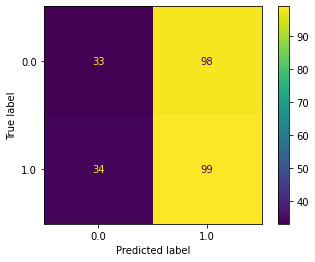

AUC - Test Set: 49.18%


In [126]:
# Regresión Logística para Arousal P
print(varAP)
LRSP1 = LogisticRegression(max_iter = 500).fit(trainX_SPAP, trainY[varAP])
prediccionesLRSP1 = LRSP1.predict(testX_SPAP)

tnLRSP1, fpLRSP1, fnLRSP1, tpLRSP1 = sklearn.metrics.confusion_matrix(testY[varAP],prediccionesLRSP1).ravel()
dfMConfCaract.loc[['TN', 'FP', 'FN','TP'], 'Arousal P - SP'] = [tnLRSP1, fpLRSP1, fnLRSP1, tpLRSP1]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(testY[varAP],prediccionesLRSP1)
plt.show()
# curva ROC
aucLRSP1, fprLRSP1, tprLRSP1, thresholdsLRSP1 = ROC(X_test =testX_SPAP , y_test= testY[varAP], model = LRSP1,grafico= False)

Arousal 5


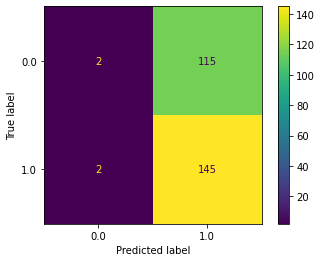

AUC - Test Set: 49.97%


In [127]:
# Regresión Logística para Arousal 5
print(varA5)
LRSP2 = LogisticRegression(max_iter = 500).fit(trainX_SPA5, trainY[varA5])
prediccionesLRSP2 = LRSP2.predict(testX_SPA5)

tnLRSP2, fpLRSP2, fnLRSP2, tpLRSP2 = sklearn.metrics.confusion_matrix(testY[varA5], prediccionesLRSP2).ravel()
dfMConfCaract.loc[['TN', 'FP', 'FN','TP'], 'Arousal 5 - SP'] = [tnLRSP2, fpLRSP2, fnLRSP2, tpLRSP2]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(testY[varA5], prediccionesLRSP2)
plt.show()
# curva ROC
aucLRSP2, fprLRSP2, tprLRSP2, thresholdsLRSP2 = ROC(X_test =testX_SPA5 , y_test= testY[varA5], model = LRSP2,grafico= False)

También se realiza con todas las características obtenidas de las señales periféricas.

In [128]:
trainSP = trainX.drop(matrizEEG.drop(['Participante','Trial'],axis=1).columns,axis=1)
testSP = testX.drop(matrizEEG.drop(['Participante','Trial'],axis=1).columns,axis=1)

Arousal P


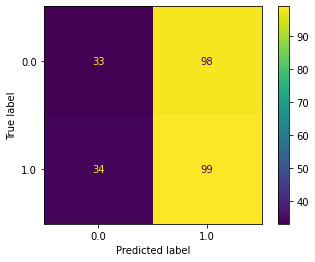

AUC - Test Set: 49.18%


In [129]:
# Regresión Logística para Arousal P con todas las señales periféricas
print(varAP)
LRSP1_tot = LogisticRegression(max_iter = 1000).fit(trainSP, trainY[varAP])
prediccionesLRSP1_tot = LRSP1_tot.predict(testSP)

tnLRSP1tot, fpLRSP1tot, fnLRSP1tot, tpLRSP1tot = sklearn.metrics.confusion_matrix(testY[varAP],prediccionesLRSP1_tot).ravel()
dfMConfCaract.loc[['TN', 'FP', 'FN','TP'], 'Arousal P - SP tot'] = [tnLRSP1tot, fpLRSP1tot, fnLRSP1tot, tpLRSP1tot]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(testY[varAP],prediccionesLRSP1_tot)
plt.show()
# curva ROC
aucLRSP1tot, fprLRSP1tot, tprLRSP1tot, thresholdsLRSP1tot = ROC(X_test =testSP , y_test= testY[varAP], model = LRSP1_tot,grafico= False)

Arousal 5


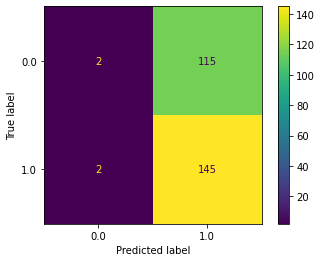

AUC - Test Set: 47.79%


In [130]:
# Regresión Logística para Arousal P con todas las señales periféricas
print(varA5)
LRSP2tot = LogisticRegression(max_iter = 500).fit(trainSP, trainY[varA5])
prediccionesLRSP2tot = LRSP2tot.predict(testSP)

tnLRSP2tot, fpLRSP2tot, fnLRSP2tot, tpLRSP2tot = sklearn.metrics.confusion_matrix(testY[varA5], prediccionesLRSP2tot).ravel()
dfMConfCaract.loc[['TN', 'FP', 'FN','TP'], 'Arousal 5 - SP tot'] = [tnLRSP2tot, fpLRSP2tot, fnLRSP2tot, tpLRSP2tot]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(testY[varA5], prediccionesLRSP2tot)
plt.show()
# curva ROC
aucLRSP2, fprLRSP2, tprLRSP2, thresholdsLRSP2 = ROC(X_test =testSP , y_test= testY[varA5], model = LRSP2tot,grafico= False)

#### Scores para Arousal y Valencia para señales perifericas y EEG


In [131]:
dfMConfCaract

Valence P - EEG  Valence 5 - EEG  ...  Arousal P - SP tot  Arousal 5 - SP tot
TN             83.0             21.0  ...                33.0                 2.0
FP             53.0             93.0  ...                98.0               115.0
FN             86.0             14.0  ...                34.0                 2.0
TP             42.0            136.0  ...                99.0               145.0

[4 rows x 16 columns]

In [132]:
dffScore_div = pd.DataFrame(columns=dfMConfCaract.columns)
for col in dffScore_div.columns: 
  tn,fp,fn,tp = dfMConfCaract.loc[['TN', 'FP', 'FN','TP'], col] 
  lista = valoresMC(tn,fp,fn,tp)
  for i in range(len(lista)):
    score = lista[i][0]
    dffScore_div.loc[score,col] = lista[i][1]
dffScore_div

Valence P - EEG  ... Arousal 5 - SP tot
Sensibilidad:         0.328125  ...           0.986395
Especificidad:        0.610294  ...           0.017094
Precision:            0.442105  ...           0.557692
Exactitud:            0.473485  ...           0.556818

[4 rows x 16 columns]

In [133]:
end = len(dffScore_div.columns)
for j in range(len(dffScore_div)):
  fila = dffScore_div.index[j]
  col_i = np.where(dffScore_div.iloc[j,0:int(end/2)]==np.max(dffScore_div.iloc[j,0:int(end/2)]))[0]
  col = dffScore_div.columns[col_i][0]
  print('Max de', fila, 'esta en ', str(col))

print()
for j in range(len(dffScore_div)):
  fila = dffScore_div.index[j]
  col_i = np.where(dffScore_div.iloc[j,int(end/2):end]==np.max(dffScore_div.iloc[j,int(end/2):end]))[0]
  col = dffScore_div.columns[col_i+int(end/2)][0]
  print('Max de', fila, 'esta en ', str(col))

Max de Sensibilidad: esta en  Valence 5 - EEG
Max de Especificidad: esta en  Valence P - SP tot
Max de Precision: esta en  Valence 5 - EEG
Max de Exactitud: esta en  Valence 5 - EEG

Max de Sensibilidad: esta en  Arousal 5 - SP
Max de Especificidad: esta en  Arousal P - EEG tot
Max de Precision: esta en  Arousal 5 - EEG
Max de Exactitud: esta en  Arousal 5 - EEG


Aplicando los modelos que arrojaron los mejores resultados para cada variable a predecir utilizando las características de las señales periféricas y de EEG por separado, incluyendo todas o únicamente las seleccionadas mediante el algoritmo de SelectKBest, se puede concluir, en primer lugar, que ambas variables se predicen con mayor efectividad cuando su binarización es realizada mediante el valor central de la escala. 

Además, por un lado, para Valencia se tiene que las características extraídas de las señales de EEG que fueron seleccionadas mediante SelectKBest son las que mejor entrenan al modelo, que en este caso se trata de Random Forest, ya que arroja las mejores méticas, principalmente teniendo en cuenta que posee el valor más alto de exactitud. De todas maneras cabe destacar que los resultados del modelo Random Forest utilizando todas las señales periféricas tiene resultados comparables y hasta un valor de AUC muy similar con el anterior. 

Por otro lado, para Arousal la situación no está tan clara, las métricas observadas para cada caso no presentan claras ventajas favoreciendo a una forma de entrenar al modelo de Regresión Logística. De todas maneras se puede concluir que las mejores serían mediante las características seleccionadas de EEG, con un valor de exactitud del 57%, y mediante las características de las señales periféricas seleccionadas, que poseen un valor de exactitud del 55%. Sin embargo, analizando los valores de AUC para cada caso (61,89% para EEG y 49.97%) se termina estableciendo que el modelo es mejor cuando se predice mediante las características de EEG.

## Resultados y conclusiones
Se observan los resultados analizados para cada situación particular del trabajo de aprendizaje automático resumidos en tablas, para luego proceder a sacar conclusiones.

In [134]:
dffScore_valencia

Valence P - RegLog  ... Valence 5 - RandForest
Sensibilidad:            0.390625  ...               0.926667
Especificidad:           0.639706  ...               0.166667
Precision:               0.505051  ...               0.594017
Exactitud:               0.518939  ...               0.598485

[4 rows x 6 columns]

In [135]:
dffScore_Arousal

Arousal P - RegLog  ... Arousal 5 - RandForest
Sensibilidad:            0.691729  ...               0.979592
Especificidad:           0.450382  ...               0.017094
Precision:               0.560976  ...               0.555985
Exactitud:                0.57197  ...                0.55303

[4 rows x 6 columns]

In [136]:
dffScore_div

Valence P - EEG  ... Arousal 5 - SP tot
Sensibilidad:         0.328125  ...           0.986395
Especificidad:        0.610294  ...           0.017094
Precision:            0.442105  ...           0.557692
Exactitud:            0.473485  ...           0.556818

[4 rows x 16 columns]

Con el fin de comparar todas las métricas para todos los clasificadores realizados se desarrolla la siguiente tabla: 


In [137]:
dfTotales = dffScore_valencia.copy().join(dffScore_div)
dfTotales = dfTotales.join(dffScore_Arousal)
print('Se realizaron en total:', str(len(dfTotales.columns)), 'metodos, los cuales presentan los siguientes Scores')
dfTotales

Se realizaron en total: 28 metodos, los cuales presentan los siguientes Scores


Valence P - RegLog  ... Arousal 5 - RandForest
Sensibilidad:            0.390625  ...               0.979592
Especificidad:           0.639706  ...               0.017094
Precision:               0.505051  ...               0.555985
Exactitud:               0.518939  ...                0.55303

[4 rows x 28 columns]

A continuación, se calculan los máximos de cada métrica para observar cual es el mejor metodo para predecir las variables de Valencia y Arousal.

In [138]:
end = len(dfTotales.columns)
for j in range(len(dfTotales)):
  fila = dfTotales.index[j]
  col_i = np.where(dfTotales.iloc[j,0:int(end/2)]==np.max(dfTotales.iloc[j,0:int(end/2)]))[0]
  col = dfTotales.columns[col_i][0]
  print('Max de', fila, 'esta en ', str(col))
  print()

print('----------------------------------------------------')
for j in range(len(dfTotales)):
  fila = dfTotales.index[j]
  col_i = np.where(dfTotales.iloc[j,int(end/2):end]==np.max(dfTotales.iloc[j,int(end/2):end]))[0]
  col = dfTotales.columns[col_i+int(end/2)][0]
  print()
  print('Max de', fila, 'esta en ', str(col))

Max de Sensibilidad: esta en  Valence 5 - SVM

Max de Especificidad: esta en  Valence P - SVM

Max de Precision: esta en  Valence 5 - RandForest

Max de Exactitud: esta en  Valence 5 - RandForest

----------------------------------------------------

Max de Sensibilidad: esta en  Arousal 5 - SP

Max de Especificidad: esta en  Arousal P - EEG tot

Max de Precision: esta en  Arousal 5 - RegLog

Max de Exactitud: esta en  Arousal 5 - RegLog


Se llega nuevamente a la conclusión que para ambas variables la manera de binarizarlas mediante el valor central de la escala total es la que mejores resultados de predicción obtiene. Esto se puede deber a que los participantes definieron los valores de cada estado emocional en base a la escala total entonces esto puede implicar que el valor del medio es el que divide entre una caracterización del estado emocional o la otra, es decir, dada una escala del 1 al 10 para definir si el estado de Valencia del participante era agradable o desagradable puede ser óptimo considerar que mayor a 5 es agradable y menor a 5 desagradable.

Para la predicción de Valencia se puede concluir mediante el análisis de sus métricas que el modelo que mejor se desempeña es el de Random Forest, utilizando las caracteristicas de las señales periféricas y EEG seleccionadas por el algoritmo de SelectKBest.

Para la predicción de Arousal se puede observar que el modelo que arrajo las mejores méticas es el de Regresión Logística, utilizando las 25 características seleccionadas extraídas a partir de las señales periféricas y de EEG.

También se calculó en general para cada métrica cual es el mejor método.

In [139]:
for fila in dfTotales.index:
  col_i = np.where(dfTotales.loc[fila]==np.max(dfTotales.loc[fila]))
  for i in col_i:
    column = dfTotales.columns[i][0]
    valor = dfTotales.loc[fila, column]
    print('Max de', fila, 'esta en ', str(column), 'con un valor de:', str(valor))
    print()

Max de Sensibilidad: esta en  Valence 5 - SVM con un valor de: 0.9933333333333333

Max de Especificidad: esta en  Valence P - SVM con un valor de: 0.8970588235294118

Max de Precision: esta en  Valence 5 - RandForest con un valor de: 0.594017094017094

Max de Exactitud: esta en  Valence 5 - RandForest con un valor de: 0.5984848484848485



Observando dichos resultados se conluye que la variable que mejor se logra predecir en el desarrollo del trabajo es la Valencia, y se lleva a cabo mediante una selección de las mejores 25 características que fueron extraídas del procesamiento de las señales periféricas (GSR, TMP y PPG) y de las señales de EEG (provenientes de 8 canales), con el método de aprendizaje automático de Random Forest. Esto se debe a que como en este caso lo que se busca es predecir correctamente un estado emocional se le da una mayor importancia a las métricas de exactitud y precisión y no tanto a las de sensibilidad y especificidad, para las cuales solo presenta un buen valor para la sensibilidad, obteniendo un valor de AUC de aproximadamente un 58% lo cual es bajo e indica un grado de confusión importante. De todas maneras, se pueden considerar aceptables estos valores para predecir el estado emocional mediante señales fisiológicas. Es notable que ambas señales analizadas y procesadas a lo largo del trabajo se complementan bien para el entrenamiento de los modelos, ya que fue de la forma en la que se obtuvieron los mejores resultados. 

## Bibliografía

[1] S. Koelstra et al., <i>"DEAP: A Database for Emotion Analysis Using Physiological Signals"</i>, IEEE Transactions on Affective Computing, vol. 3, no. 1, pp. 18-31, 2012. Available: 10.1109/t-affc.2011.15 [Accessed 14 Feb 2022].

[2] S. Koelstra, "DEAP: A Dataset for Emotion Analysis using Physiological and Audiovisual Signals", Eecs.qmul.ac.uk, 2021. [Online]. Available: http://www.eecs.qmul.ac.uk/mmv/datasets/deap/readme.html. [Accessed: 14 Feb 2022].

[3] J. Semmlow and B. Griffel, <i>Biosignal and Medical Image Processing, Third Edition</i>, 3rd ed. CRC Press, 2014.

[4] Laguna, et. al. Bioelectrical signal processing in cardiac and neurological applications.